In [ ]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.


# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

# **The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [5]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


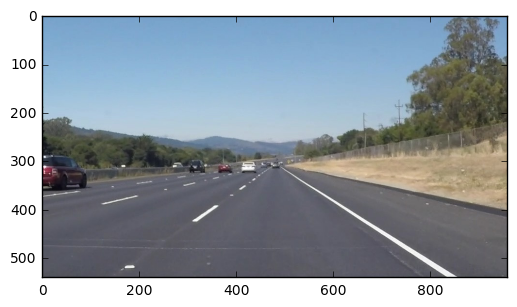

In [6]:
### reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [7]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_linear_regression_line(coef, intercept, intersection_x, img, imshape=[540,960], color=[255, 0, 0], thickness=6):

    # Get starting and ending points of regression line, ints.
    print("Coef: ", coef, "Intercept: ", intercept,
          "intersection_x: ", intersection_x)
    point_one = (int(intersection_x), int(intersection_x * coef + intercept))
    point_two = (int((imshape[0] - intercept) / coef),imshape[0])
    print("Point one: ", point_one, "Point two: ", point_two)

    # Draw line using cv2.line
    cv2.line(img, point_one, point_two, color, thickness)
def find_line_fit(slope_intercept):
    """slope_intercept is an array [[slope, intercept], [slope, intercept]...]."""

    # Initialise arrays
    kept_slopes = []
    kept_intercepts = []
    #print("Slope & intercept: ", slope_intercept)
    if len(slope_intercept) == 1:
        return slope_intercept[0][0], slope_intercept[0][1]

    # Remove points with slope not within 1.5 standard deviations of the mean
    slopes = [pair[0] for pair in slope_intercept]
    slope_mean = np.mean(slopes)
    slope_std = np.std(slopes)
    for pair in slope_intercept:
        slope = pair[0]
        if slope - slope_mean < 1.5 * slope_std:
            kept_slopes.append(slope)
            kept_intercepts.append(pair[1])
    if not kept_slopes:
        kept_slopes = slopes
        kept_intercepts = [pair[1] for pair in slope_intercept]
    # Take estimate of slope, intercept to be the mean of remaining values
    slope = np.mean(kept_slopes)
    intercept = np.mean(kept_intercepts)
    #print("Slope: ", slope, "Intercept: ", intercept)
    return slope, intercept

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    positive_slope_intercept = []
    negative_slope_intercept = []
    for line in lines:
        print('type of line',type(line), line)
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            print('slope:',slope)
            if math.isfinite(slope) :
                if slope > 0:
                    positive_slope_intercept.append([slope, y1-slope*x1])
                elif slope < 0:
                    negative_slope_intercept.append([slope, y1-slope*x1])

    if not positive_slope_intercept or not negative_slope_intercept:
        return
    # Get intercept and coefficient of fitted lines
    pos_coef, pos_intercept = find_line_fit(positive_slope_intercept)
    neg_coef, neg_intercept = find_line_fit(negative_slope_intercept)

    intersection_x = (pos_intercept - neg_intercept)/(neg_coef - pos_coef)
    draw_linear_regression_line(pos_coef, pos_intercept, intersection_x, img)
    draw_linear_regression_line(neg_coef, neg_intercept, intersection_x, img)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [8]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

In [9]:
## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

SyntaxError: invalid syntax (<ipython-input-9-5ee77d102a54>, line 3)

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [11]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    gray_img = grayscale(image)
    kernel_size = 5
    blur_gray = gaussian_blur(gray_img, kernel_size)
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(450, 330), (490, 330), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 45   # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40 #minimum number of pixels making up a line
    max_line_gap = 100    # maximum gap in pixels between connectable line segments
    lines = hough_lines(masked_edges,rho,theta,threshold,min_line_length,max_line_gap)

    final_image = weighted_img(lines, image)

    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimesions:', final_image.shape)
    #plt.imshow(final_image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
    #plt.show()
    return final_image

Let's try the one with the solid white lane on the right first ...

In [12]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

type of line <class 'numpy.ndarray'> [[618 387 870 538]]
slope: 0.599206349206
type of line <class 'numpy.ndarray'> [[593 376 782 498]]
slope: 0.645502645503
type of line <class 'numpy.ndarray'> [[651 407 869 538]]
slope: 0.600917431193
type of line <class 'numpy.ndarray'> [[187 513 416 347]]
slope: -0.724890829694
type of line <class 'numpy.ndarray'> [[621 393 833 530]]
slope: 0.646226415094
type of line <class 'numpy.ndarray'> [[200 515 433 339]]
slope: -0.755364806867
type of line <class 'numpy.ndarray'> [[187 512 415 347]]
slope: -0.723684210526
type of line <class 'numpy.ndarray'> [[203 514 432 341]]
slope: -0.755458515284
type of line <class 'numpy.ndarray'> [[767 487 847 539]]
slope: 0.65
Coef:  0.628370568199 Intercept:  1.17071118548 intersection_x:  479.5704315
Point one:  (479, 302) Point two:  (857, 540)
Coef:  -0.739849590593 Intercept:  657.328643124 intersection_x:  479.5704315
Point one:  (479, 302) Point two:  (158, 540)
This image is: <class 'numpy.ndarray'> with dime

  0%|          | 0/222 [00:00<?, ?it/s]  3%|▎         | 7/222 [00:00<00:03, 67.65it/s]

type of line <class 'numpy.ndarray'> [[618 387 870 538]]
slope: 0.599206349206
type of line <class 'numpy.ndarray'> [[593 376 782 498]]
slope: 0.645502645503
type of line <class 'numpy.ndarray'> [[651 407 869 538]]
slope: 0.600917431193
type of line <class 'numpy.ndarray'> [[187 513 416 347]]
slope: -0.724890829694
type of line <class 'numpy.ndarray'> [[621 393 833 530]]
slope: 0.646226415094
type of line <class 'numpy.ndarray'> [[200 515 433 339]]
slope: -0.755364806867
type of line <class 'numpy.ndarray'> [[187 512 415 347]]
slope: -0.723684210526
type of line <class 'numpy.ndarray'> [[203 514 432 341]]
slope: -0.755458515284
type of line <class 'numpy.ndarray'> [[767 487 847 539]]
slope: 0.65
Coef:  0.628370568199 Intercept:  1.17071118548 intersection_x:  479.5704315
Point one:  (479, 302) Point two:  (857, 540)
Coef:  -0.739849590593 Intercept:  657.328643124 intersection_x:  479.5704315
Point one:  (479, 302) Point two:  (158, 540)
This image is: <class 'numpy.ndarray'> with dime

  7%|▋         | 15/222 [00:00<00:03, 67.96it/s] 10%|▉         | 22/222 [00:00<00:02, 66.69it/s]


slope: 0.623529411765
type of line <class 'numpy.ndarray'> [[142 538 411 350]]
slope: -0.698884758364
type of line <class 'numpy.ndarray'> [[653 420 835 539]]
slope: 0.653846153846
type of line <class 'numpy.ndarray'> [[634 407 835 538]]
slope: 0.651741293532
type of line <class 'numpy.ndarray'> [[598 378 821 517]]
slope: 0.62331838565
type of line <class 'numpy.ndarray'> [[575 368 696 447]]
slope: 0.652892561983
type of line <class 'numpy.ndarray'> [[162 538 412 350]]
slope: -0.752
type of line <class 'numpy.ndarray'> [[142 539 422 343]]
slope: -0.7
Coef:  0.641065561355 Intercept:  -2.13756844054 intersection_x:  476.642003467
Point one:  (476, 303) Point two:  (845, 540)
Coef:  -0.716961586121 Intercept:  645.155211896 intersection_x:  476.642003467
Point one:  (476, 303) Point two:  (146, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[609 383 859 539]]
slope: 0.624
type of line <class 'numpy.ndarray'> [[587 373 767 

 13%|█▎        | 29/222 [00:00<00:02, 66.07it/s] 17%|█▋        | 37/222 [00:00<00:02, 67.73it/s]

Point one:  (482, 307) Point two:  (847, 540)
Coef:  -0.708413764949 Intercept:  649.157568216 intersection_x:  482.597299652
Point one:  (482, 307) Point two:  (154, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[596 377 855 538]]
slope: 0.621621621622
type of line <class 'numpy.ndarray'> [[567 364 833 537]]
slope: 0.65037593985
type of line <class 'numpy.ndarray'> [[165 538 225 494]]
slope: -0.733333333333
type of line <class 'numpy.ndarray'> [[329 412 430 344]]
slope: -0.673267326733
type of line <class 'numpy.ndarray'> [[142 539 213 491]]
slope: -0.676056338028
type of line <class 'numpy.ndarray'> [[665 428 834 538]]
slope: 0.650887573964
type of line <class 'numpy.ndarray'> [[147 536 215 491]]
slope: -0.661764705882
Coef:  0.640961711812 Intercept:  -1.02996035587 intersection_x:  483.190362155
Point one:  (483, 308) Point two:  (844, 540)
Coef:  -0.686105425994 Intercept:  640.196090565 intersection_x:  483.1903621

 20%|██        | 45/222 [00:00<00:02, 68.97it/s]

type of line <class 'numpy.ndarray'> [[598 378 854 538]]
slope: 0.625
type of line <class 'numpy.ndarray'> [[664 426 832 539]]
slope: 0.672619047619
type of line <class 'numpy.ndarray'> [[576 368 719 464]]
slope: 0.671328671329
type of line <class 'numpy.ndarray'> [[602 380 855 538]]
slope: 0.624505928854
type of line <class 'numpy.ndarray'> [[580 370 778 503]]
slope: 0.671717171717
type of line <class 'numpy.ndarray'> [[284 442 419 344]]
slope: -0.725925925926
Coef:  0.653034163904 Intercept:  -10.1205782141 intersection_x:  477.376789968
Point one:  (477, 301) Point two:  (842, 540)
Coef:  -0.725925925926 Intercept:  648.162962963 intersection_x:  477.376789968
Point one:  (477, 301) Point two:  (149, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[606 383 854 538]]
slope: 0.625
type of line <class 'numpy.ndarray'> [[578 369 781 505]]
slope: 0.669950738916
type of line <class 'numpy.ndarray'> [[600 379 853 537]]
slope: 

 23%|██▎       | 52/222 [00:00<00:03, 47.57it/s]

type of line <class 'numpy.ndarray'> [[578 369 830 539]]
slope: 0.674603174603
type of line <class 'numpy.ndarray'> [[141 538 414 347]]
slope: -0.699633699634
type of line <class 'numpy.ndarray'> [[603 380 755 478]]
slope: 0.644736842105
type of line <class 'numpy.ndarray'> [[162 537 292 442]]
slope: -0.730769230769
type of line <class 'numpy.ndarray'> [[679 428 822 520]]
slope: 0.643356643357
type of line <class 'numpy.ndarray'> [[786 496 853 539]]
slope: 0.641791044776
type of line <class 'numpy.ndarray'> [[161 539 416 347]]
slope: -0.752941176471
Coef:  0.643294843413 Intercept:  -8.68774594089 intersection_x:  480.96517573
Point one:  (480, 300) Point two:  (852, 540)
Coef:  -0.727781368958 Intercept:  650.752165482 intersection_x:  480.96517573
Point one:  (480, 300) Point two:  (152, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[580 370 831 539]]
slope: 0.673306772908
type of line <class 'numpy.ndarray'> [[598 378

 26%|██▌       | 58/222 [00:01<00:03, 48.98it/s]

type of line <class 'numpy.ndarray'> [[586 373 850 538]]
slope: 0.625
type of line <class 'numpy.ndarray'> [[564 363 755 491]]
slope: 0.670157068063
type of line <class 'numpy.ndarray'> [[703 455 828 539]]
slope: 0.672
type of line <class 'numpy.ndarray'> [[585 372 851 538]]
slope: 0.624060150376
type of line <class 'numpy.ndarray'> [[286 436 412 351]]
slope: -0.674603174603
type of line <class 'numpy.ndarray'> [[294 437 435 338]]
slope: -0.702127659574
type of line <class 'numpy.ndarray'> [[647 412 850 539]]
slope: 0.625615763547
type of line <class 'numpy.ndarray'> [[298 436 435 337]]
slope: -0.722627737226
Coef:  0.643366596397 Intercept:  -2.29663467443 intersection_x:  479.120228279
Point one:  (479, 305) Point two:  (842, 540)
Coef:  -0.699786190468 Intercept:  641.235035182 intersection_x:  479.120228279
Point one:  (479, 305) Point two:  (144, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 29%|██▉       | 65/222 [00:01<00:02, 52.46it/s]

type of line <class 'numpy.ndarray'> [[564 363 770 501]]
slope: 0.669902912621
type of line <class 'numpy.ndarray'> [[584 372 850 538]]
slope: 0.624060150376
type of line <class 'numpy.ndarray'> [[644 410 849 538]]
slope: 0.624390243902
type of line <class 'numpy.ndarray'> [[588 378 827 539]]
slope: 0.673640167364
type of line <class 'numpy.ndarray'> [[271 454 445 332]]
slope: -0.701149425287
type of line <class 'numpy.ndarray'> [[260 452 418 345]]
slope: -0.677215189873
type of line <class 'numpy.ndarray'> [[260 453 420 345]]
slope: -0.675
type of line <class 'numpy.ndarray'> [[585 372 654 415]]
slope: 0.623188405797
type of line <class 'numpy.ndarray'> [[560 361 721 469]]
slope: 0.670807453416
Coef:  0.647664888913 Intercept:  -4.11691622093 intersection_x:  478.670223908
Point one:  (478, 305) Point two:  (840, 540)
Coef:  -0.68445487172 Intercept:  633.529147873 intersection_x:  478.670223908
Point one:  (478, 305) Point two:  (136, 540)
This image is: <class 'numpy.ndarray'> with 

 32%|███▏      | 72/222 [00:01<00:02, 56.48it/s]

 <class 'numpy.ndarray'> [[588 374 817 522]]
slope: 0.646288209607
type of line <class 'numpy.ndarray'> [[560 361 821 537]]
slope: 0.674329501916
type of line <class 'numpy.ndarray'> [[556 359 822 538]]
slope: 0.672932330827
type of line <class 'numpy.ndarray'> [[670 426 844 539]]
slope: 0.649425287356
type of line <class 'numpy.ndarray'> [[273 449 432 338]]
slope: -0.698113207547
type of line <class 'numpy.ndarray'> [[584 372 737 471]]
slope: 0.647058823529
type of line <class 'numpy.ndarray'> [[261 449 403 353]]
slope: -0.676056338028
Coef:  0.658006830647 Intercept:  -10.5579319463 intersection_x:  478.090663303
Point one:  (478, 304) Point two:  (836, 540)
Coef:  -0.687084772788 Intercept:  632.517804943 intersection_x:  478.090663303
Point one:  (478, 304) Point two:  (134, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[560 361 821 537]]
slope: 0.674329501916
type of line <class 'numpy.ndarray'> [[596 379 843 539]]


 36%|███▌      | 79/222 [00:01<00:02, 58.75it/s]

type of line <class 'numpy.ndarray'> [[561 363 821 539]]
slope: 0.676923076923
type of line <class 'numpy.ndarray'> [[655 417 842 538]]
slope: 0.647058823529
type of line <class 'numpy.ndarray'> [[187 496 423 343]]
slope: -0.648305084746
type of line <class 'numpy.ndarray'> [[558 360 820 537]]
slope: 0.675572519084
type of line <class 'numpy.ndarray'> [[582 371 788 504]]
slope: 0.645631067961
type of line <class 'numpy.ndarray'> [[202 498 427 341]]
slope: -0.697777777778
type of line <class 'numpy.ndarray'> [[189 494 415 347]]
slope: -0.650442477876
type of line <class 'numpy.ndarray'> [[201 498 402 357]]
slope: -0.701492537313
Coef:  0.661296371874 Intercept:  -11.326030692 intersection_x:  478.630839638
Point one:  (478, 305) Point two:  (833, 540)
Coef:  -0.674504469428 Intercept:  628.029447569 intersection_x:  478.630839638
Point one:  (478, 305) Point two:  (130, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[556 3

 39%|███▊      | 86/222 [00:01<00:02, 61.11it/s]


type of line <class 'numpy.ndarray'> [[228 465 399 354]]
slope: -0.649122807018
Coef:  0.677045221321 Intercept:  -18.1232734888 intersection_x:  477.22007676
Point one:  (477, 304) Point two:  (824, 540)
Coef:  -0.655570697577 Intercept:  617.827797619 intersection_x:  477.22007676
Point one:  (477, 304) Point two:  (118, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[549 356 810 538]]
slope: 0.697318007663
type of line <class 'numpy.ndarray'> [[591 380 833 538]]
slope: 0.652892561983
type of line <class 'numpy.ndarray'> [[182 496 398 356]]
slope: -0.648148148148
type of line <class 'numpy.ndarray'> [[194 498 429 340]]
slope: -0.672340425532
type of line <class 'numpy.ndarray'> [[567 364 779 502]]
slope: 0.650943396226
type of line <class 'numpy.ndarray'> [[558 361 811 538]]
slope: 0.699604743083
type of line <class 'numpy.ndarray'> [[708 457 832 538]]
slope: 0.653225806452
Coef:  0.670796903081 Intercept:  -14.5270627

 42%|████▏     | 93/222 [00:01<00:02, 60.53it/s]

type of line <class 'numpy.ndarray'> [[553 358 810 538]]
slope: 0.700389105058
type of line <class 'numpy.ndarray'> [[577 371 805 520]]
slope: 0.65350877193
type of line <class 'numpy.ndarray'> [[136 538 427 342]]
slope: -0.6735395189
type of line <class 'numpy.ndarray'> [[117 539 408 350]]
slope: -0.649484536082
type of line <class 'numpy.ndarray'> [[551 357 810 539]]
slope: 0.702702702703
type of line <class 'numpy.ndarray'> [[137 538 426 343]]
slope: -0.674740484429
type of line <class 'numpy.ndarray'> [[569 365 748 482]]
slope: 0.653631284916
type of line <class 'numpy.ndarray'> [[694 448 832 538]]
slope: 0.652173913043
Coef:  0.67248115553 Intercept:  -15.4207644919 intersection_x:  478.503928629
Point one:  (478, 306) Point two:  (825, 540)
Coef:  -0.665921513137 Intercept:  625.010170553 intersection_x:  478.503928629
Point one:  (478, 306) Point two:  (127, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[571 367 7

 45%|████▌     | 100/222 [00:01<00:02, 60.85it/s] 48%|████▊     | 107/222 [00:01<00:01, 61.63it/s]

0.68
type of line <class 'numpy.ndarray'> [[719 471 812 538]]
slope: 0.720430107527
type of line <class 'numpy.ndarray'> [[116 538 245 455]]
slope: -0.643410852713
Coef:  0.704946761753 Intercept:  -39.3304521599 intersection_x:  484.35325944
Point one:  (484, 302) Point two:  (821, 540)
Coef:  -0.660976495163 Intercept:  622.258929473 intersection_x:  484.35325944
Point one:  (484, 302) Point two:  (124, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[582 372 813 539]]
slope: 0.722943722944
type of line <class 'numpy.ndarray'> [[593 376 833 538]]
slope: 0.675
type of line <class 'numpy.ndarray'> [[117 538 214 476]]
slope: -0.639175257732
type of line <class 'numpy.ndarray'> [[136 538 224 478]]
slope: -0.681818181818
type of line <class 'numpy.ndarray'> [[137 538 223 480]]
slope: -0.674418604651
type of line <class 'numpy.ndarray'> [[700 449 833 539]]
slope: 0.676691729323
type of line <class 'numpy.ndarray'> [[596 377 69

 51%|█████▏    | 114/222 [00:01<00:01, 59.59it/s] 55%|█████▍    | 121/222 [00:02<00:01, 59.73it/s]

type of line <class 'numpy.ndarray'> [[575 368 818 538]]
slope: 0.699588477366
type of line <class 'numpy.ndarray'> [[602 381 740 474]]
slope: 0.673913043478
type of line <class 'numpy.ndarray'> [[604 381 838 538]]
slope: 0.67094017094
type of line <class 'numpy.ndarray'> [[324 410 427 341]]
slope: -0.669902912621
type of line <class 'numpy.ndarray'> [[576 368 817 537]]
slope: 0.701244813278
type of line <class 'numpy.ndarray'> [[326 412 427 346]]
slope: -0.653465346535
type of line <class 'numpy.ndarray'> [[153 538 446 333]]
slope: -0.699658703072
type of line <class 'numpy.ndarray'> [[323 410 409 352]]
slope: -0.674418604651
type of line <class 'numpy.ndarray'> [[133 538 224 479]]
slope: -0.648351648352
type of line <class 'numpy.ndarray'> [[598 378 808 519]]
slope: 0.671428571429
Coef:  0.683423015298 Intercept:  -28.527637614 intersection_x:  486.747728321
Point one:  (486, 304) Point two:  (831, 540)
Coef:  -0.669159443046 Intercept:  629.838801353 intersection_x:  486.747728321
P

 58%|█████▊    | 128/222 [00:02<00:01, 54.24it/s]

type of line <class 'numpy.ndarray'> [[613 392 830 538]]
slope: 0.672811059908
type of line <class 'numpy.ndarray'> [[648 408 828 524]]
slope: 0.644444444444
type of line <class 'numpy.ndarray'> [[573 367 647 416]]
slope: 0.662162162162
type of line <class 'numpy.ndarray'> [[130 538 446 333]]
slope: -0.648734177215
type of line <class 'numpy.ndarray'> [[151 538 445 332]]
slope: -0.700680272109
type of line <class 'numpy.ndarray'> [[576 368 830 539]]
slope: 0.673228346457
type of line <class 'numpy.ndarray'> [[608 383 777 492]]
slope: 0.644970414201
type of line <class 'numpy.ndarray'> [[158 519 225 475]]
slope: -0.65671641791
type of line <class 'numpy.ndarray'> [[725 457 852 539]]
slope: 0.645669291339
type of line <class 'numpy.ndarray'> [[374 379 441 334]]
slope: -0.671641791045
Coef:  0.657214286418 Intercept:  -13.747312376 intersection_x:  485.069193181
Point one:  (485, 305) Point two:  (842, 540)
Coef:  -0.66944316457 Intercept:  629.773347002 intersection_x:  485.069193181
Poi

 60%|██████    | 134/222 [00:02<00:01, 51.53it/s] 63%|██████▎   | 140/222 [00:02<00:01, 49.88it/s]

type of line <class 'numpy.ndarray'> [[576 368 838 538]]
slope: 0.648854961832
type of line <class 'numpy.ndarray'> [[575 368 837 538]]
slope: 0.648854961832
type of line <class 'numpy.ndarray'> [[603 380 828 520]]
slope: 0.622222222222
type of line <class 'numpy.ndarray'> [[230 492 451 332]]
slope: -0.723981900452
type of line <class 'numpy.ndarray'> [[215 490 437 340]]
slope: -0.675675675676
type of line <class 'numpy.ndarray'> [[693 437 860 538]]
slope: 0.604790419162
type of line <class 'numpy.ndarray'> [[228 493 407 358]]
slope: -0.754189944134
Coef:  0.631180641262 Intercept:  2.96204461306 intersection_x:  481.756279635
Point one:  (481, 307) Point two:  (850, 540)
Coef:  -0.717949173421 Intercept:  652.913804879 intersection_x:  481.756279635
Point one:  (481, 307) Point two:  (157, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[702 450 838 539]]
slope: 0.654411764706
type of line <class 'numpy.ndarray'> [[654 41

 66%|██████▌   | 146/222 [00:02<00:01, 49.68it/s]

type of line <class 'numpy.ndarray'> [[576 368 837 538]]
slope: 0.651340996169
type of line <class 'numpy.ndarray'> [[603 380 834 524]]
slope: 0.623376623377
type of line <class 'numpy.ndarray'> [[316 430 449 330]]
slope: -0.751879699248
type of line <class 'numpy.ndarray'> [[307 428 453 330]]
slope: -0.671232876712
type of line <class 'numpy.ndarray'> [[578 369 692 443]]
slope: 0.649122807018
type of line <class 'numpy.ndarray'> [[682 438 837 539]]
slope: 0.651612903226
Coef:  0.639693840561 Intercept:  -2.3664270132 intersection_x:  483.402482096
Point one:  (483, 306) Point two:  (847, 540)
Coef:  -0.71155628798 Intercept:  650.831239057 intersection_x:  483.402482096
Point one:  (483, 306) Point two:  (155, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[576 368 838 538]]
slope: 0.648854961832
type of line <class 'numpy.ndarray'> [[605 381 859 539]]
slope: 0.622047244094
type of line <class 'numpy.ndarray'> [[713 458 

 68%|██████▊   | 152/222 [00:02<00:01, 49.00it/s] 71%|███████   | 158/222 [00:02<00:01, 51.19it/s]

[[769 488 848 539]]
slope: 0.645569620253
type of line <class 'numpy.ndarray'> [[251 473 443 334]]
slope: -0.723958333333
type of line <class 'numpy.ndarray'> [[264 472 447 334]]
slope: -0.754098360656
Coef:  0.624615550084 Intercept:  2.82816177618 intersection_x:  484.048360483
Point one:  (484, 305) Point two:  (860, 540)
Coef:  -0.739028346995 Intercept:  662.89775444 intersection_x:  484.048360483
Point one:  (484, 305) Point two:  (166, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[602 380 847 539]]
slope: 0.648979591837
type of line <class 'numpy.ndarray'> [[623 389 775 483]]
slope: 0.618421052632
type of line <class 'numpy.ndarray'> [[596 377 818 521]]
slope: 0.648648648649
type of line <class 'numpy.ndarray'> [[743 462 863 536]]
slope: 0.616666666667
type of line <class 'numpy.ndarray'> [[329 414 443 334]]
slope: -0.701754385965
type of line <class 'numpy.ndarray'> [[334 418 451 330]]
slope: -0.752136752137
typ

 74%|███████▍  | 165/222 [00:02<00:01, 52.98it/s] 77%|███████▋  | 171/222 [00:03<00:00, 53.02it/s]

<class 'numpy.ndarray'> [[650 401 820 499]]
slope: 0.576470588235
type of line <class 'numpy.ndarray'> [[707 434 886 538]]
slope: 0.581005586592
type of line <class 'numpy.ndarray'> [[275 470 455 330]]
slope: -0.777777777778
type of line <class 'numpy.ndarray'> [[259 473 445 333]]
slope: -0.752688172043
type of line <class 'numpy.ndarray'> [[612 384 792 493]]
slope: 0.605555555556
Coef:  0.596077081532 Intercept:  16.2850473007 intersection_x:  484.557145745
Point one:  (484, 305) Point two:  (878, 540)
Coef:  -0.76523297491 Intercept:  675.917562724 intersection_x:  484.557145745
Point one:  (484, 305) Point two:  (177, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[650 401 884 536]]
slope: 0.576923076923
type of line <class 'numpy.ndarray'> [[609 383 802 499]]
slope: 0.60103626943
type of line <class 'numpy.ndarray'> [[806 492 886 539]]
slope: 0.5875
type of line <class 'numpy.ndarray'> [[649 401 886 538]]
slope: 0.578

 80%|███████▉  | 177/222 [00:03<00:00, 54.03it/s] 82%|████████▏ | 183/222 [00:03<00:00, 54.50it/s]

type of line <class 'numpy.ndarray'> [[596 377 865 538]]
slope: 0.598513011152
type of line <class 'numpy.ndarray'> [[636 395 886 539]]
slope: 0.576
type of line <class 'numpy.ndarray'> [[594 376 865 539]]
slope: 0.60147601476
type of line <class 'numpy.ndarray'> [[631 393 802 491]]
slope: 0.573099415205
type of line <class 'numpy.ndarray'> [[309 447 448 334]]
slope: -0.812949640288
type of line <class 'numpy.ndarray'> [[303 444 445 333]]
slope: -0.781690140845
Coef:  0.587272110279 Intercept:  24.7619403979 intersection_x:  480.116044986
Point one:  (480, 306) Point two:  (877, 540)
Coef:  -0.797319890566 Intercept:  689.526775762 intersection_x:  480.116044986
Point one:  (480, 306) Point two:  (187, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[632 393 885 539]]
slope: 0.577075098814
type of line <class 'numpy.ndarray'> [[594 376 864 539]]
slope: 0.603703703704
type of line <class 'numpy.ndarray'> [[625 390 822 503]]

 85%|████████▌ | 189/222 [00:03<00:00, 55.74it/s] 88%|████████▊ | 195/222 [00:03<00:00, 56.74it/s]

slope: 0.620192307692
type of line <class 'numpy.ndarray'> [[700 436 866 539]]
slope: 0.620481927711
type of line <class 'numpy.ndarray'> [[753 461 887 539]]
slope: 0.582089552239
type of line <class 'numpy.ndarray'> [[622 389 714 446]]
slope: 0.619565217391
type of line <class 'numpy.ndarray'> [[318 430 431 342]]
slope: -0.778761061947
type of line <class 'numpy.ndarray'> [[329 431 448 331]]
slope: -0.840336134454
Coef:  0.604345629333 Intercept:  10.9143689384 intersection_x:  482.103909016
Point one:  (482, 302) Point two:  (875, 540)
Coef:  -0.8095485982 Intercept:  692.558302967 intersection_x:  482.103909016
Point one:  (482, 302) Point two:  (188, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[650 401 880 534]]
slope: 0.578260869565
type of line <class 'numpy.ndarray'> [[654 408 865 539]]
slope: 0.620853080569
type of line <class 'numpy.ndarray'> [[622 389 745 465]]
slope: 0.617886178862
type of line <class 'numpy

 91%|█████████ | 201/222 [00:03<00:00, 56.13it/s] 93%|█████████▎| 207/222 [00:03<00:00, 54.84it/s]

type of line <class 'numpy.ndarray'> [[611 384 869 539]]
slope: 0.600775193798
type of line <class 'numpy.ndarray'> [[652 402 889 538]]
slope: 0.573839662447
type of line <class 'numpy.ndarray'> [[650 406 868 537]]
slope: 0.600917431193
type of line <class 'numpy.ndarray'> [[659 405 890 538]]
slope: 0.575757575758
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[642 401 871 538]]
slope: 0.598253275109
type of line <class 'numpy.ndarray'> [[675 414 891 538]]
slope: 0.574074074074
type of line <class 'numpy.ndarray'> [[612 384 871 539]]
slope: 0.598455598456
type of line <class 'numpy.ndarray'> [[295 449 443 333]]
slope: -0.783783783784
type of line <class 'numpy.ndarray'> [[311 447 446 334]]
slope: -0.837037037037
type of line <class 'numpy.ndarray'> [[654 403 891 539]]
slope: 0.573839662447
Coef:  0.586155652522 Intercept:  22.2188579711 intersection_x:  480.856958522
Point one:  (480, 304) Point two:  (883, 540)
Coef:  -0.8104

 96%|█████████▌| 213/222 [00:03<00:00, 53.22it/s] 99%|█████████▊| 219/222 [00:03<00:00, 54.57it/s]

type of line <class 'numpy.ndarray'> [[638 396 885 538]]
slope: 0.574898785425
type of line <class 'numpy.ndarray'> [[688 418 906 539]]
slope: 0.55504587156
type of line <class 'numpy.ndarray'> [[697 422 907 538]]
slope: 0.552380952381
type of line <class 'numpy.ndarray'> [[199 538 435 340]]
slope: -0.838983050847
type of line <class 'numpy.ndarray'> [[178 538 230 498]]
slope: -0.769230769231
type of line <class 'numpy.ndarray'> [[199 539 445 333]]
slope: -0.837398373984
type of line <class 'numpy.ndarray'> [[177 538 227 499]]
slope: -0.78
Coef:  0.560775203122 Intercept:  34.1111638187 intersection_x:  480.02854091
Point one:  (480, 303) Point two:  (902, 540)
Coef:  -0.806403048515 Intercept:  690.395745116 intersection_x:  480.02854091
Point one:  (480, 303) Point two:  (186, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[636 395 885 538]]
slope: 0.574297188755
type of line <class 'numpy.ndarray'> [[685 417 906 539]]


100%|█████████▉| 221/222 [00:03<00:00, 56.03it/s]


<class 'numpy.ndarray'> [[175 538 451 330]]
slope: -0.753623188406
type of line <class 'numpy.ndarray'> [[641 397 896 539]]
slope: 0.556862745098
type of line <class 'numpy.ndarray'> [[603 380 783 484]]
slope: 0.577777777778
type of line <class 'numpy.ndarray'> [[241 487 446 332]]
slope: -0.756097560976
type of line <class 'numpy.ndarray'> [[698 436 874 538]]
slope: 0.579545454545
type of line <class 'numpy.ndarray'> [[196 538 436 344]]
slope: -0.808333333333
Coef:  0.56966569909 Intercept:  35.0229991257 intersection_x:  479.228313077
Point one:  (479, 308) Point two:  (886, 540)
Coef:  -0.782700771675 Intercept:  683.115301572 intersection_x:  479.228313077
Point one:  (479, 308) Point two:  (182, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[643 398 896 538]]
slope: 0.553359683794
type of line <class 'numpy.ndarray'> [[603 380 876 538]]
slope: 0.578754578755
type of line <class 'numpy.ndarray'> [[195 539 239 503]]
sl

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [14]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

type of line <class 'numpy.ndarray'> [[148 511 433 339]]
slope: -0.60350877193
type of line <class 'numpy.ndarray'> [[105 538 334 400]]
slope: -0.602620087336
type of line <class 'numpy.ndarray'> [[124 538 282 439]]
slope: -0.626582278481
type of line <class 'numpy.ndarray'> [[217 479 440 339]]
slope: -0.627802690583
type of line <class 'numpy.ndarray'> [[286 435 444 336]]
slope: -0.626582278481
type of line <class 'numpy.ndarray'> [[573 367 759 497]]
slope: 0.698924731183
type of line <class 'numpy.ndarray'> [[605 386 774 496]]
slope: 0.650887573964
type of line <class 'numpy.ndarray'> [[603 389 757 497]]
slope: 0.701298701299
type of line <class 'numpy.ndarray'> [[607 386 775 495]]
slope: 0.64880952381
type of line <class 'numpy.ndarray'> [[125 538 210 485]]
slope: -0.623529411765
Coef:  0.674980132564 Intercept:  -20.7453377629 intersection_x:  488.001603927
Point one:  (488, 308) Point two:  (830, 540)
Coef:  -0.618437586429 Intercept:  610.444583653 intersection_x:  488.001603927


  0%|          | 0/682 [00:00<?, ?it/s]  1%|          | 8/682 [00:00<00:08, 75.82it/s]

type of line <class 'numpy.ndarray'> [[148 511 433 339]]
slope: -0.60350877193
type of line <class 'numpy.ndarray'> [[105 538 334 400]]
slope: -0.602620087336
type of line <class 'numpy.ndarray'> [[124 538 282 439]]
slope: -0.626582278481
type of line <class 'numpy.ndarray'> [[217 479 440 339]]
slope: -0.627802690583
type of line <class 'numpy.ndarray'> [[286 435 444 336]]
slope: -0.626582278481
type of line <class 'numpy.ndarray'> [[573 367 759 497]]
slope: 0.698924731183
type of line <class 'numpy.ndarray'> [[605 386 774 496]]
slope: 0.650887573964
type of line <class 'numpy.ndarray'> [[603 389 757 497]]
slope: 0.701298701299
type of line <class 'numpy.ndarray'> [[607 386 775 495]]
slope: 0.64880952381
type of line <class 'numpy.ndarray'> [[125 538 210 485]]
slope: -0.623529411765
Coef:  0.674980132564 Intercept:  -20.7453377629 intersection_x:  488.001603927
Point one:  (488, 308) Point two:  (830, 540)
Coef:  -0.618437586429 Intercept:  610.444583653 intersection_x:  488.001603927


  2%|▏         | 15/682 [00:00<00:09, 73.71it/s]  4%|▎         | 24/682 [00:00<00:08, 75.85it/s]

 -0.666583619421 Intercept:  631.941638364 intersection_x:  486.065838461
Point one:  (486, 307) Point two:  (137, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[131 538 443 335]]
slope: -0.650641025641
type of line <class 'numpy.ndarray'> [[206 502 437 340]]
slope: -0.701298701299
type of line <class 'numpy.ndarray'> [[643 404 860 539]]
slope: 0.622119815668
type of line <class 'numpy.ndarray'> [[734 470 839 538]]
slope: 0.647619047619
type of line <class 'numpy.ndarray'> [[226 478 434 338]]
slope: -0.673076923077
type of line <class 'numpy.ndarray'> [[152 539 276 452]]
slope: -0.701612903226
type of line <class 'numpy.ndarray'> [[269 450 445 332]]
slope: -0.670454545455
type of line <class 'numpy.ndarray'> [[755 472 861 538]]
slope: 0.622641509434
type of line <class 'numpy.ndarray'> [[169 515 235 471]]
slope: -0.666666666667
Coef:  0.630793457574 Intercept:  0.176745983441 intersection_x:  484.476643882
Point one:  (4

  5%|▍         | 32/682 [00:00<00:08, 74.71it/s]  6%|▌         | 40/682 [00:00<00:08, 75.23it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[191 519 374 386]]
slope: -0.726775956284
type of line <class 'numpy.ndarray'> [[142 538 418 351]]
slope: -0.677536231884
type of line <class 'numpy.ndarray'> [[163 538 406 361]]
slope: -0.728395061728
type of line <class 'numpy.ndarray'> [[143 538 411 357]]
slope: -0.675373134328
type of line <class 'numpy.ndarray'> [[280 444 424 346]]
slope: -0.680555555556
type of line <class 'numpy.ndarray'> [[163 539 388 375]]
slope: -0.728888888889
type of line <class 'numpy.ndarray'> [[354 393 416 348]]
slope: -0.725806451613
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[164 538 373 386]]
slope: -0.727272727273
type of line <class 'numpy.ndarray'> [[164 523 415 353]]
slope: -0.677290836653
type of line <class 'numpy.ndarray'> [[143 538 405 361]]
slope: -0.675572519084
type of line <class 'numpy.ndarray'> [[302 430 415 348]]
slope

  7%|▋         | 48/682 [00:00<00:08, 73.33it/s]  8%|▊         | 55/682 [00:00<00:08, 70.15it/s]


slope: -0.755813953488
type of line <class 'numpy.ndarray'> [[145 538 428 340]]
slope: -0.69964664311
type of line <class 'numpy.ndarray'> [[217 501 392 369]]
slope: -0.754285714286
type of line <class 'numpy.ndarray'> [[145 539 430 339]]
slope: -0.701754385965
type of line <class 'numpy.ndarray'> [[287 438 385 369]]
slope: -0.704081632653
type of line <class 'numpy.ndarray'> [[618 391 669 422]]
slope: 0.607843137255
type of line <class 'numpy.ndarray'> [[629 392 678 421]]
slope: 0.591836734694
Coef:  0.599839935974 Intercept:  17.543817527 intersection_x:  477.975026532
Point one:  (477, 304) Point two:  (870, 540)
Coef:  -0.7231164659 Intercept:  649.883938813 intersection_x:  477.975026532
Point one:  (477, 304) Point two:  (151, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[166 539 420 347]]
slope: -0.755905511811
type of line <class 'numpy.ndarray'> [[146 538 430 339]]
slope: -0.700704225352
type of line <class 'n

  9%|▉         | 62/682 [00:00<00:09, 68.63it/s] 10%|█         | 69/682 [00:00<00:09, 66.95it/s]

type of line <class 'numpy.ndarray'> [[241 478 427 342]]
slope: -0.731182795699
type of line <class 'numpy.ndarray'> [[140 539 417 345]]
slope: -0.70036101083
type of line <class 'numpy.ndarray'> [[140 538 413 347]]
slope: -0.699633699634
type of line <class 'numpy.ndarray'> [[161 537 376 380]]
slope: -0.73023255814
type of line <class 'numpy.ndarray'> [[619 394 671 426]]
slope: 0.615384615385
type of line <class 'numpy.ndarray'> [[624 392 680 424]]
slope: 0.571428571429
type of line <class 'numpy.ndarray'> [[160 538 277 453]]
slope: -0.726495726496
type of line <class 'numpy.ndarray'> [[307 429 432 338]]
slope: -0.728
Coef:  0.593406593407 Intercept:  24.2527472527 intersection_x:  475.220476109
Point one:  (475, 306) Point two:  (869, 540)
Coef:  -0.7193176318 Intercept:  648.086178555 intersection_x:  475.220476109
Point one:  (475, 306) Point two:  (150, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[140 539 417 345]

 11%|█         | 76/682 [00:01<00:09, 63.78it/s]

 <class 'numpy.ndarray'> [[196 511 437 336]]
slope: -0.726141078838
type of line <class 'numpy.ndarray'> [[137 538 435 337]]
slope: -0.674496644295
type of line <class 'numpy.ndarray'> [[157 539 289 443]]
slope: -0.727272727273
type of line <class 'numpy.ndarray'> [[273 456 423 347]]
slope: -0.726666666667
type of line <class 'numpy.ndarray'> [[614 388 667 418]]
slope: 0.566037735849
type of line <class 'numpy.ndarray'> [[267 451 422 343]]
slope: -0.696774193548
type of line <class 'numpy.ndarray'> [[575 368 658 420]]
slope: 0.626506024096
Coef:  0.596271879973 Intercept:  24.1059331666 intersection_x:  475.394893771
Point one:  (475, 307) Point two:  (865, 540)
Coef:  -0.719213666581 Intercept:  649.481044828 intersection_x:  475.394893771
Point one:  (475, 307) Point two:  (152, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[137 538 437 336]]
slope: -0.673333333333
type of line <class 'numpy.ndarray'> [[160 537 432 340

 12%|█▏        | 83/682 [00:01<00:09, 64.31it/s]

slope: 0.669491525424
type of line <class 'numpy.ndarray'> [[155 538 213 496]]
slope: -0.724137931034
type of line <class 'numpy.ndarray'> [[244 476 434 338]]
slope: -0.726315789474
Coef:  0.669491525424 Intercept:  -17.6779661017 intersection_x:  480.176382403
Point one:  (480, 303) Point two:  (832, 540)
Coef:  -0.704482873982 Intercept:  642.072090519 intersection_x:  480.176382403
Point one:  (480, 303) Point two:  (144, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[133 538 394 362]]
slope: -0.674329501916
type of line <class 'numpy.ndarray'> [[154 539 426 342]]
slope: -0.724264705882
type of line <class 'numpy.ndarray'> [[211 499 435 337]]
slope: -0.723214285714
type of line <class 'numpy.ndarray'> [[134 539 270 447]]
slope: -0.676470588235
type of line <class 'numpy.ndarray'> [[605 382 651 410]]
slope: 0.608695652174
type of line <class 'numpy.ndarray'> [[600 384 746 482]]
slope: 0.671232876712
Coef:  0.6399642644

 13%|█▎        | 90/682 [00:01<00:09, 60.05it/s]

type of line <class 'numpy.ndarray'> [[155 538 415 350]]
slope: -0.723076923077
type of line <class 'numpy.ndarray'> [[133 538 391 364]]
slope: -0.674418604651
type of line <class 'numpy.ndarray'> [[266 459 435 337]]
slope: -0.721893491124
type of line <class 'numpy.ndarray'> [[261 451 419 344]]
slope: -0.677215189873
type of line <class 'numpy.ndarray'> [[575 368 661 424]]
slope: 0.651162790698
type of line <class 'numpy.ndarray'> [[615 388 669 421]]
slope: 0.611111111111
type of line <class 'numpy.ndarray'> [[613 388 658 415]]
slope: 0.6
type of line <class 'numpy.ndarray'> [[134 537 402 356]]
slope: -0.675373134328
Coef:  0.62075796727 Intercept:  8.64935400517 intersection_x:  477.633190923
Point one:  (477, 305) Point two:  (855, 540)
Coef:  -0.694395468611 Intercept:  636.810286138 intersection_x:  477.633190923
Point one:  (477, 305) Point two:  (139, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[132 538 419 344]

 14%|█▍        | 96/682 [00:01<00:10, 54.26it/s] 15%|█▍        | 102/682 [00:01<00:11, 50.99it/s]

type of line <class 'numpy.ndarray'> [[136 539 435 337]]
slope: -0.675585284281
type of line <class 'numpy.ndarray'> [[156 538 430 346]]
slope: -0.700729927007
type of line <class 'numpy.ndarray'> [[155 538 445 334]]
slope: -0.703448275862
type of line <class 'numpy.ndarray'> [[268 451 447 331]]
slope: -0.670391061453
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[156 538 434 343]]
slope: -0.701438848921
type of line <class 'numpy.ndarray'> [[136 539 437 336]]
slope: -0.674418604651
type of line <class 'numpy.ndarray'> [[201 496 429 342]]
slope: -0.675438596491
type of line <class 'numpy.ndarray'> [[239 479 445 334]]
slope: -0.703883495146
type of line <class 'numpy.ndarray'> [[156 539 341 409]]
slope: -0.702702702703
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[137 538 437 336]]
slope: -0.673333333333
type of line <class 'numpy.ndarray'> [[196 500 449 330]]
slope

 16%|█▌        | 108/682 [00:01<00:11, 48.14it/s]

0.602996254682
type of line <class 'numpy.ndarray'> [[274 453 435 340]]
slope: -0.701863354037
type of line <class 'numpy.ndarray'> [[571 366 833 523]]
slope: 0.599236641221
type of line <class 'numpy.ndarray'> [[569 366 823 531]]
slope: 0.649606299213
Coef:  0.620302198105 Intercept:  13.0952151685 intersection_x:  477.701462562
Point one:  (477, 309) Point two:  (849, 540)
Coef:  -0.695557434667 Intercept:  641.683286269 intersection_x:  477.701462562
Point one:  (477, 309) Point two:  (146, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[134 539 426 342]]
slope: -0.674657534247
type of line <class 'numpy.ndarray'> [[155 538 407 361]]
slope: -0.702380952381
type of line <class 'numpy.ndarray'> [[708 458 832 538]]
slope: 0.645161290323
type of line <class 'numpy.ndarray'> [[134 538 292 432]]
slope: -0.670886075949
type of line <class 'numpy.ndarray'> [[632 400 854 539]]
slope: 0.626126126126
type of line <class 'numpy.nd

 17%|█▋        | 114/682 [00:01<00:11, 49.09it/s] 17%|█▋        | 119/682 [00:01<00:11, 48.53it/s]

(480, 308) Point two:  (144, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[157 538 387 377]]
slope: -0.7
type of line <class 'numpy.ndarray'> [[158 525 447 331]]
slope: -0.671280276817
type of line <class 'numpy.ndarray'> [[137 539 425 344]]
slope: -0.677083333333
type of line <class 'numpy.ndarray'> [[156 538 415 356]]
slope: -0.702702702703
type of line <class 'numpy.ndarray'> [[564 363 711 458]]
slope: 0.646258503401
type of line <class 'numpy.ndarray'> [[598 380 714 452]]
slope: 0.620689655172
type of line <class 'numpy.ndarray'> [[562 362 710 458]]
slope: 0.648648648649
type of line <class 'numpy.ndarray'> [[339 409 445 334]]
slope: -0.707547169811
type of line <class 'numpy.ndarray'> [[601 380 722 455]]
slope: 0.619834710744
type of line <class 'numpy.ndarray'> [[136 538 198 497]]
slope: -0.661290322581
Coef:  0.633857879492 Intercept:  3.06914714774 intersection_x:  481.723943716
Point one:  (481, 308) Point two:

 18%|█▊        | 125/682 [00:02<00:11, 50.60it/s] 19%|█▉        | 131/682 [00:02<00:10, 51.61it/s]


Point one:  (478, 308) Point two:  (854, 540)
Coef:  -0.717540007002 Intercept:  651.855643481 intersection_x:  478.878254547
Point one:  (478, 308) Point two:  (155, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[180 526 451 330]]
slope: -0.723247232472
type of line <class 'numpy.ndarray'> [[222 485 433 338]]
slope: -0.696682464455
type of line <class 'numpy.ndarray'> [[261 459 439 335]]
slope: -0.696629213483
type of line <class 'numpy.ndarray'> [[180 513 304 427]]
slope: -0.693548387097
type of line <class 'numpy.ndarray'> [[585 374 679 437]]
slope: 0.670212765957
type of line <class 'numpy.ndarray'> [[631 399 686 432]]
slope: 0.6
type of line <class 'numpy.ndarray'> [[161 538 310 433]]
slope: -0.704697986577
type of line <class 'numpy.ndarray'> [[141 538 219 487]]
slope: -0.653846153846
type of line <class 'numpy.ndarray'> [[586 373 691 436]]
slope: 0.6
Coef:  0.623404255319 Intercept:  7.9085106383 intersection_x: 

 20%|██        | 138/682 [00:02<00:10, 53.71it/s] 21%|██▏       | 145/682 [00:02<00:09, 56.87it/s]

Intercept:  12.1383666275 intersection_x:  480.604668006
Point one:  (480, 309) Point two:  (854, 540)
Coef:  -0.699880171972 Intercept:  645.422850672 intersection_x:  480.604668006
Point one:  (480, 309) Point two:  (150, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[143 538 396 367]]
slope: -0.675889328063
type of line <class 'numpy.ndarray'> [[171 534 446 335]]
slope: -0.723636363636
type of line <class 'numpy.ndarray'> [[142 538 410 357]]
slope: -0.675373134328
type of line <class 'numpy.ndarray'> [[164 539 435 342]]
slope: -0.726937269373
type of line <class 'numpy.ndarray'> [[584 375 669 430]]
slope: 0.647058823529
type of line <class 'numpy.ndarray'> [[262 469 454 330]]
slope: -0.723958333333
type of line <class 'numpy.ndarray'> [[627 396 678 428]]
slope: 0.627450980392
Coef:  0.637254901961 Intercept:  -0.147058823529 intersection_x:  483.297638404
Point one:  (483, 307) Point two:  (847, 540)
Coef:  -0.7051588

 22%|██▏       | 151/682 [00:02<00:09, 55.38it/s] 23%|██▎       | 157/682 [00:02<00:09, 56.19it/s]

type of line <class 'numpy.ndarray'> [[169 535 437 341]]
slope: -0.723880597015
type of line <class 'numpy.ndarray'> [[262 456 447 331]]
slope: -0.675675675676
type of line <class 'numpy.ndarray'> [[163 538 413 357]]
slope: -0.724
type of line <class 'numpy.ndarray'> [[142 538 305 428]]
slope: -0.674846625767
type of line <class 'numpy.ndarray'> [[582 373 659 423]]
slope: 0.649350649351
type of line <class 'numpy.ndarray'> [[143 537 356 393]]
slope: -0.676056338028
type of line <class 'numpy.ndarray'> [[618 391 669 421]]
slope: 0.588235294118
type of line <class 'numpy.ndarray'> [[365 385 432 340]]
slope: -0.671641791045
Coef:  0.618792971734 Intercept:  11.2742551566 intersection_x:  480.525597441
Point one:  (480, 308) Point two:  (854, 540)
Coef:  -0.691016837922 Intercept:  640.671396475 intersection_x:  480.525597441
Point one:  (480, 308) Point two:  (145, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[163 539 415 

 24%|██▍       | 163/682 [00:02<00:09, 55.35it/s]

 482.398844483
Point one:  (482, 313) Point two:  (159, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[172 538 388 382]]
slope: -0.722222222222
type of line <class 'numpy.ndarray'> [[264 461 447 337]]
slope: -0.677595628415
type of line <class 'numpy.ndarray'> [[155 536 460 330]]
slope: -0.675409836066
type of line <class 'numpy.ndarray'> [[369 397 460 331]]
slope: -0.725274725275
type of line <class 'numpy.ndarray'> [[556 359 658 422]]
slope: 0.617647058824
type of line <class 'numpy.ndarray'> [[153 538 249 473]]
slope: -0.677083333333
type of line <class 'numpy.ndarray'> [[585 373 667 420]]
slope: 0.573170731707
Coef:  0.595408895265 Intercept:  26.6416786227 intersection_x:  482.724434435
Point one:  (482, 314) Point two:  (862, 540)
Coef:  -0.695517149062 Intercept:  649.803223268 intersection_x:  482.724434435
Point one:  (482, 314) Point two:  (157, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 

 25%|██▍       | 169/682 [00:02<00:09, 55.31it/s]

type of line <class 'numpy.ndarray'> [[278 456 459 330]]
slope: -0.696132596685
type of line <class 'numpy.ndarray'> [[158 539 439 342]]
slope: -0.701067615658
type of line <class 'numpy.ndarray'> [[177 538 435 350]]
slope: -0.728682170543
type of line <class 'numpy.ndarray'> [[158 538 241 480]]
slope: -0.698795180723
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[161 537 455 332]]
slope: -0.697278911565
type of line <class 'numpy.ndarray'> [[178 538 403 374]]
slope: -0.728888888889
type of line <class 'numpy.ndarray'> [[228 501 436 349]]
slope: -0.730769230769
type of line <class 'numpy.ndarray'> [[158 539 440 341]]
slope: -0.702127659574
type of line <class 'numpy.ndarray'> [[332 419 459 330]]
slope: -0.700787401575
type of line <class 'numpy.ndarray'> [[385 386 442 344]]
slope: -0.736842105263
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line

 26%|██▌       | 176/682 [00:02<00:08, 57.38it/s]

 <class 'numpy.ndarray'> [[160 538 457 330]]
slope: -0.700336700337
type of line <class 'numpy.ndarray'> [[192 528 407 371]]
slope: -0.73023255814
type of line <class 'numpy.ndarray'> [[179 538 358 408]]
slope: -0.72625698324
type of line <class 'numpy.ndarray'> [[315 431 447 335]]
slope: -0.727272727273
type of line <class 'numpy.ndarray'> [[278 466 459 330]]
slope: -0.75138121547
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[160 538 458 330]]
slope: -0.697986577181
type of line <class 'numpy.ndarray'> [[212 516 459 330]]
slope: -0.753036437247
type of line <class 'numpy.ndarray'> [[286 461 444 342]]
slope: -0.753164556962
type of line <class 'numpy.ndarray'> [[181 538 295 453]]
slope: -0.745614035088
type of line <class 'numpy.ndarray'> [[161 539 453 334]]
slope: -0.702054794521
type of line <class 'numpy.ndarray'> [[616 390 658 415]]
slope: 0.595238095238
Coef:  0.595238095238 Intercept:  23.3333333333 intersection_x:  48

 27%|██▋       | 182/682 [00:03<00:08, 57.87it/s]

slope: -0.728682170543
type of line <class 'numpy.ndarray'> [[593 376 676 424]]
slope: 0.578313253012
type of line <class 'numpy.ndarray'> [[832 514 873 539]]
slope: 0.609756097561
Coef:  0.594034675287 Intercept:  19.8715838966 intersection_x:  486.443876894
Point one:  (486, 308) Point two:  (875, 540)
Coef:  -0.740866277339 Intercept:  669.22597856 intersection_x:  486.443876894
Point one:  (486, 308) Point two:  (174, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[192 538 458 330]]
slope: -0.781954887218
type of line <class 'numpy.ndarray'> [[171 538 457 330]]
slope: -0.727272727273
type of line <class 'numpy.ndarray'> [[192 539 428 354]]
slope: -0.783898305085
type of line <class 'numpy.ndarray'> [[375 389 451 330]]
slope: -0.776315789474
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[191 538 458 330]]
slope: -0.779026217228
type of line <class 'numpy.ndar

 28%|██▊       | 189/682 [00:03<00:08, 59.98it/s]

slope: -0.726315789474
type of line <class 'numpy.ndarray'> [[193 538 428 354]]
slope: -0.782978723404
type of line <class 'numpy.ndarray'> [[247 482 422 354]]
slope: -0.731428571429
type of line <class 'numpy.ndarray'> [[339 416 429 348]]
slope: -0.755555555556
type of line <class 'numpy.ndarray'> [[606 383 731 452]]
slope: 0.552
Coef:  0.552 Intercept:  48.488 intersection_x:  479.161287814
Point one:  (479, 312) Point two:  (890, 540)
Coef:  -0.755060971418 Intercept:  674.781018317 intersection_x:  479.161287814
Point one:  (479, 312) Point two:  (178, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[171 538 458 330]]
slope: -0.724738675958
type of line <class 'numpy.ndarray'> [[193 538 459 330]]
slope: -0.781954887218
type of line <class 'numpy.ndarray'> [[192 538 456 332]]
slope: -0.780303030303
type of line <class 'numpy.ndarray'> [[321 428 426 351]]
slope: -0.733333333333
type of line <class 'numpy.ndarray'> [[173 

 29%|██▊       | 196/682 [00:03<00:08, 60.62it/s]

type of line <class 'numpy.ndarray'> [[171 539 447 331]]
slope: -0.753623188406
type of line <class 'numpy.ndarray'> [[174 537 449 330]]
slope: -0.752727272727
type of line <class 'numpy.ndarray'> [[190 538 379 390]]
slope: -0.783068783069
type of line <class 'numpy.ndarray'> [[299 452 454 330]]
slope: -0.787096774194
type of line <class 'numpy.ndarray'> [[191 539 261 484]]
slope: -0.785714285714
type of line <class 'numpy.ndarray'> [[382 386 453 330]]
slope: -0.788732394366
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[171 538 445 332]]
slope: -0.751824817518
type of line <class 'numpy.ndarray'> [[172 539 449 330]]
slope: -0.754512635379
type of line <class 'numpy.ndarray'> [[190 538 446 337]]
slope: -0.78515625
type of line <class 'numpy.ndarray'> [[387 381 454 330]]
slope: -0.761194029851
type of line <class 'numpy.ndarray'> [[191 538 339 422]]
slope: -0.783783783784
type of line <class 'numpy.ndarray'> [[604 385 738 462]

 30%|██▉       | 203/682 [00:03<00:08, 58.52it/s]

type of line <class 'numpy.ndarray'> [[171 539 449 330]]
slope: -0.751798561151
type of line <class 'numpy.ndarray'> [[191 538 384 387]]
slope: -0.782383419689
type of line <class 'numpy.ndarray'> [[314 440 454 330]]
slope: -0.785714285714
type of line <class 'numpy.ndarray'> [[612 390 658 415]]
slope: 0.54347826087
type of line <class 'numpy.ndarray'> [[378 382 443 333]]
slope: -0.753846153846
type of line <class 'numpy.ndarray'> [[171 537 451 333]]
slope: -0.728571428571
Coef:  0.54347826087 Intercept:  57.3913043478 intersection_x:  472.419677446
Point one:  (472, 314) Point two:  (888, 540)
Coef:  -0.7684356051 Intercept:  677.165229746 intersection_x:  472.419677446
Point one:  (472, 314) Point two:  (178, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[233 493 450 330]]
slope: -0.751152073733
type of line <class 'numpy.ndarray'> [[190 538 454 331]]
slope: -0.784090909091
type of line <class 'numpy.ndarray'> [[171 53

 31%|███       | 209/682 [00:03<00:08, 57.80it/s] 32%|███▏      | 215/682 [00:03<00:07, 58.40it/s]

 <class 'numpy.ndarray'> [[186 537 398 372]]
slope: -0.778301886792
type of line <class 'numpy.ndarray'> [[183 539 447 332]]
slope: -0.784090909091
type of line <class 'numpy.ndarray'> [[327 428 453 330]]
slope: -0.777777777778
type of line <class 'numpy.ndarray'> [[339 411 423 350]]
slope: -0.72619047619
type of line <class 'numpy.ndarray'> [[195 514 440 336]]
slope: -0.726530612245
type of line <class 'numpy.ndarray'> [[164 538 436 340]]
slope: -0.727941176471
type of line <class 'numpy.ndarray'> [[388 382 454 330]]
slope: -0.787878787879
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[162 539 441 336]]
slope: -0.727598566308
type of line <class 'numpy.ndarray'> [[162 538 447 331]]
slope: -0.726315789474
type of line <class 'numpy.ndarray'> [[328 425 453 330]]
slope: -0.76
type of line <class 'numpy.ndarray'> [[241 492 447 336]]
slope: -0.757281553398
type of line <class 'numpy.ndarray'> [[183 537 382 387]]
slope: -0.7537688

 32%|███▏      | 221/682 [00:03<00:07, 58.67it/s] 33%|███▎      | 228/682 [00:03<00:07, 59.38it/s]

[[542 353 630 400]]
slope: 0.534090909091
Coef:  0.534090909091 Intercept:  63.5227272727 intersection_x:  470.919165117
Point one:  (470, 315) Point two:  (892, 540)
Coef:  -0.726425150038 Intercept:  657.123897454 intersection_x:  470.919165117
Point one:  (470, 315) Point two:  (161, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[151 539 450 330]]
slope: -0.698996655518
type of line <class 'numpy.ndarray'> [[217 506 449 331]]
slope: -0.754310344828
type of line <class 'numpy.ndarray'> [[151 538 251 468]]
slope: -0.7
type of line <class 'numpy.ndarray'> [[286 455 444 336]]
slope: -0.753164556962
type of line <class 'numpy.ndarray'> [[172 539 281 457]]
slope: -0.752293577982
type of line <class 'numpy.ndarray'> [[544 354 737 470]]
slope: 0.60103626943
type of line <class 'numpy.ndarray'> [[285 446 437 336]]
slope: -0.723684210526
type of line <class 'numpy.ndarray'> [[556 359 643 407]]
slope: 0.551724137931
Coef:  0.576

 34%|███▍      | 235/682 [00:03<00:07, 59.24it/s] 35%|███▌      | 241/682 [00:04<00:07, 58.90it/s]

type of line <class 'numpy.ndarray'> [[166 538 450 331]]
slope: -0.728873239437
type of line <class 'numpy.ndarray'> [[167 538 435 343]]
slope: -0.727611940299
type of line <class 'numpy.ndarray'> [[266 457 433 340]]
slope: -0.700598802395
type of line <class 'numpy.ndarray'> [[147 539 439 335]]
slope: -0.698630136986
type of line <class 'numpy.ndarray'> [[147 538 258 461]]
slope: -0.693693693694
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[167 539 431 347]]
slope: -0.727272727273
type of line <class 'numpy.ndarray'> [[225 486 439 336]]
slope: -0.700934579439
type of line <class 'numpy.ndarray'> [[147 539 308 427]]
slope: -0.695652173913
type of line <class 'numpy.ndarray'> [[315 430 452 330]]
slope: -0.729927007299
type of line <class 'numpy.ndarray'> [[167 538 442 338]]
slope: -0.727272727273
type of line <class 'numpy.ndarray'> [[606 390 646 415]]
slope: 0.625
Coef:  0.625 Intercept:  11.25 intersection_x:  478.456444416

 36%|███▋      | 248/682 [00:04<00:07, 61.55it/s]

type of line <class 'numpy.ndarray'> [[168 537 442 338]]
slope: -0.726277372263
type of line <class 'numpy.ndarray'> [[144 538 452 330]]
slope: -0.675324675325
type of line <class 'numpy.ndarray'> [[165 538 451 330]]
slope: -0.727272727273
type of line <class 'numpy.ndarray'> [[249 466 450 330]]
slope: -0.676616915423
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[145 538 446 335]]
slope: -0.674418604651
type of line <class 'numpy.ndarray'> [[166 539 443 338]]
slope: -0.725631768953
type of line <class 'numpy.ndarray'> [[200 500 452 330]]
slope: -0.674603174603
type of line <class 'numpy.ndarray'> [[563 365 625 401]]
slope: 0.58064516129
Coef:  0.58064516129 Intercept:  38.0967741935 intersection_x:  475.785018612
Point one:  (475, 314) Point two:  (864, 540)
Coef:  -0.691551182736 Intercept:  643.388735414 intersection_x:  475.785018612
Point one:  (475, 314) Point two:  (149, 540)
This image is: <class 'numpy.ndarray'> with

 37%|███▋      | 255/682 [00:04<00:06, 61.71it/s]


slope: -0.730769230769
type of line <class 'numpy.ndarray'> [[148 539 435 338]]
slope: -0.700348432056
type of line <class 'numpy.ndarray'> [[220 490 407 359]]
slope: -0.700534759358
type of line <class 'numpy.ndarray'> [[551 357 864 538]]
slope: 0.578274760383
type of line <class 'numpy.ndarray'> [[568 368 843 539]]
slope: 0.621818181818
type of line <class 'numpy.ndarray'> [[357 400 452 330]]
slope: -0.736842105263
type of line <class 'numpy.ndarray'> [[340 413 433 345]]
slope: -0.731182795699
type of line <class 'numpy.ndarray'> [[168 538 391 376]]
slope: -0.726457399103
type of line <class 'numpy.ndarray'> [[587 379 843 538]]
slope: 0.62109375
type of line <class 'numpy.ndarray'> [[568 366 850 529]]
slope: 0.578014184397
type of line <class 'numpy.ndarray'> [[149 538 215 492]]
slope: -0.69696969697
Coef:  0.59980021915 Intercept:  26.3209479421 intersection_x:  476.221071424
Point one:  (476, 311) Point two:  (856, 540)
Coef:  -0.717586345603 Intercept:  653.688189288 intersection

 38%|███▊      | 262/682 [00:04<00:06, 61.96it/s]

type of line <class 'numpy.ndarray'> [[198 520 451 330]]
slope: -0.750988142292
type of line <class 'numpy.ndarray'> [[151 539 397 366]]
slope: -0.70325203252
type of line <class 'numpy.ndarray'> [[151 538 429 343]]
slope: -0.701438848921
type of line <class 'numpy.ndarray'> [[172 539 446 333]]
slope: -0.751824817518
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[152 539 348 401]]
slope: -0.704081632653
type of line <class 'numpy.ndarray'> [[175 537 448 332]]
slope: -0.750915750916
type of line <class 'numpy.ndarray'> [[269 455 439 335]]
slope: -0.705882352941
type of line <class 'numpy.ndarray'> [[151 538 411 356]]
slope: -0.7
type of line <class 'numpy.ndarray'> [[565 365 695 446]]
slope: 0.623076923077
Coef:  0.623076923077 Intercept:  12.9615384615 intersection_x:  476.56968817
Point one:  (476, 309) Point two:  (845, 540)
Coef:  -0.715219934127 Intercept:  650.753254379 intersection_x:  476.56968817
Point one:  (476, 309

 39%|███▉      | 269/682 [00:04<00:06, 62.08it/s]


slope: 0.569620253165
type of line <class 'numpy.ndarray'> [[223 488 449 330]]
slope: -0.699115044248
type of line <class 'numpy.ndarray'> [[149 538 261 460]]
slope: -0.696428571429
type of line <class 'numpy.ndarray'> [[780 487 869 538]]
slope: 0.573033707865
Coef:  0.572455534903 Intercept:  39.9344621057 intersection_x:  475.735618219
Point one:  (475, 312) Point two:  (873, 540)
Coef:  -0.707982727359 Intercept:  649.084550393 intersection_x:  475.735618219
Point one:  (475, 312) Point two:  (154, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[170 538 452 333]]
slope: -0.72695035461
type of line <class 'numpy.ndarray'> [[150 539 449 330]]
slope: -0.698996655518
type of line <class 'numpy.ndarray'> [[169 538 455 330]]
slope: -0.727272727273
type of line <class 'numpy.ndarray'> [[274 453 450 330]]
slope: -0.698863636364
type of line <class 'numpy.ndarray'> [[586 374 672 428]]
slope: 0.627906976744
Coef:  0.62790697674

 40%|████      | 276/682 [00:04<00:06, 62.92it/s]

<class 'numpy.ndarray'> [[282 448 449 331]]
slope: -0.700598802395
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[171 538 375 390]]
slope: -0.725490196078
type of line <class 'numpy.ndarray'> [[151 538 449 330]]
slope: -0.697986577181
type of line <class 'numpy.ndarray'> [[170 538 453 332]]
slope: -0.727915194346
type of line <class 'numpy.ndarray'> [[225 488 449 331]]
slope: -0.700892857143
type of line <class 'numpy.ndarray'> [[151 539 448 331]]
slope: -0.700336700337
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[201 505 451 330]]
slope: -0.7
type of line <class 'numpy.ndarray'> [[171 538 454 332]]
slope: -0.727915194346
type of line <class 'numpy.ndarray'> [[152 538 294 439]]
slope: -0.697183098592
type of line <class 'numpy.ndarray'> [[172 539 380 388]]
slope: -0.725961538462
type of line <class 'numpy.ndarray'> [[286 454 456 330]]
slope: -0.729411764706
type o

 41%|████▏     | 283/682 [00:04<00:06, 61.23it/s]

type of line <class 'numpy.ndarray'> [[154 539 445 335]]
slope: -0.701030927835
type of line <class 'numpy.ndarray'> [[156 537 447 333]]
slope: -0.701030927835
type of line <class 'numpy.ndarray'> [[173 538 445 340]]
slope: -0.727941176471
type of line <class 'numpy.ndarray'> [[331 422 451 334]]
slope: -0.733333333333
type of line <class 'numpy.ndarray'> [[539 353 671 426]]
slope: 0.55303030303
type of line <class 'numpy.ndarray'> [[174 538 400 374]]
slope: -0.725663716814
type of line <class 'numpy.ndarray'> [[612 388 674 426]]
slope: 0.612903225806
type of line <class 'numpy.ndarray'> [[827 511 874 538]]
slope: 0.574468085106
type of line <class 'numpy.ndarray'> [[811 513 853 538]]
slope: 0.595238095238
type of line <class 'numpy.ndarray'> [[335 388 401 388]]
slope: 0.0
type of line <class 'numpy.ndarray'> [[208 512 447 338]]
slope: -0.728033472803
Coef:  0.583909927295 Intercept:  33.499172713 intersection_x:  479.341660469
Point one:  (479, 313) Point two:  (867, 540)
Coef:  -0.719

 43%|████▎     | 290/682 [00:04<00:06, 59.83it/s]

 <class 'numpy.ndarray'> [[156 538 441 338]]
slope: -0.701754385965
type of line <class 'numpy.ndarray'> [[217 508 454 330]]
slope: -0.751054852321
type of line <class 'numpy.ndarray'> [[162 533 448 332]]
slope: -0.702797202797
type of line <class 'numpy.ndarray'> [[175 538 389 383]]
slope: -0.724299065421
type of line <class 'numpy.ndarray'> [[365 399 451 334]]
slope: -0.755813953488
type of line <class 'numpy.ndarray'> [[526 346 715 455]]
slope: 0.57671957672
type of line <class 'numpy.ndarray'> [[313 400 389 400]]
slope: 0.0
type of line <class 'numpy.ndarray'> [[556 359 728 454]]
slope: 0.552325581395
Coef:  0.564522579057 Intercept:  47.2762396948 intersection_x:  475.130234279
Point one:  (475, 315) Point two:  (872, 540)
Coef:  -0.727143891998 Intercept:  660.986032698 intersection_x:  475.130234279
Point one:  (475, 315) Point two:  (166, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[193 525 397 372]]
slope: -0.

 44%|████▎     | 297/682 [00:04<00:06, 58.49it/s] 45%|████▍     | 304/682 [00:05<00:06, 60.54it/s]


Point one:  (472, 317) Point two:  (895, 540)
Coef:  -0.722453037828 Intercept:  658.304201549 intersection_x:  472.040026982
Point one:  (472, 317) Point two:  (163, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[154 538 452 330]]
slope: -0.697986577181
type of line <class 'numpy.ndarray'> [[176 538 451 331]]
slope: -0.752727272727
type of line <class 'numpy.ndarray'> [[323 429 441 340]]
slope: -0.754237288136
type of line <class 'numpy.ndarray'> [[154 539 398 368]]
slope: -0.700819672131
type of line <class 'numpy.ndarray'> [[176 539 445 336]]
slope: -0.754646840149
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[154 538 451 330]]
slope: -0.700336700337
type of line <class 'numpy.ndarray'> [[174 539 448 333]]
slope: -0.751824817518
type of line <class 'numpy.ndarray'> [[217 508 440 340]]
slope: -0.7533632287
type of line <class 'numpy.ndarray'> [[153 538 450 

 46%|████▌     | 311/682 [00:05<00:06, 61.01it/s]

 -0.702054794521
type of line <class 'numpy.ndarray'> [[171 523 420 348]]
slope: -0.70281124498
type of line <class 'numpy.ndarray'> [[182 531 436 340]]
slope: -0.751968503937
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[150 538 443 333]]
slope: -0.699658703072
type of line <class 'numpy.ndarray'> [[173 537 447 331]]
slope: -0.751824817518
type of line <class 'numpy.ndarray'> [[170 538 317 428]]
slope: -0.748299319728
type of line <class 'numpy.ndarray'> [[322 426 423 350]]
slope: -0.752475247525
type of line <class 'numpy.ndarray'> [[571 367 729 466]]
slope: 0.626582278481
Coef:  0.626582278481 Intercept:  9.22151898734 intersection_x:  477.430724675
Point one:  (477, 308) Point two:  (847, 540)
Coef:  -0.75086646159 Intercept:  666.857869162 intersection_x:  477.430724675
Point one:  (477, 308) Point two:  (168, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> 

 47%|████▋     | 318/682 [00:05<00:06, 60.43it/s]


type of line <class 'numpy.ndarray'> [[243 473 393 368]]
slope: -0.7
type of line <class 'numpy.ndarray'> [[147 539 254 464]]
slope: -0.700934579439
type of line <class 'numpy.ndarray'> [[770 492 846 539]]
slope: 0.618421052632
type of line <class 'numpy.ndarray'> [[556 359 658 418]]
slope: 0.578431372549
type of line <class 'numpy.ndarray'> [[166 538 409 361]]
slope: -0.728395061728
type of line <class 'numpy.ndarray'> [[167 538 390 376]]
slope: -0.726457399103
type of line <class 'numpy.ndarray'> [[784 490 856 533]]
slope: 0.597222222222
type of line <class 'numpy.ndarray'> [[183 514 420 348]]
slope: -0.700421940928
type of line <class 'numpy.ndarray'> [[391 368 435 337]]
slope: -0.704545454545
type of line <class 'numpy.ndarray'> [[785 490 868 538]]
slope: 0.578313253012
Coef:  0.584655615928 Intercept:  31.7313436754 intersection_x:  476.046735597
Point one:  (476, 310) Point two:  (869, 540)
Coef:  -0.716019378745 Intercept:  650.913428963 intersection_x:  476.046735597
Point one

 48%|████▊     | 325/682 [00:05<00:06, 58.78it/s]

type of line <class 'numpy.ndarray'> [[160 530 387 371]]
slope: -0.700440528634
type of line <class 'numpy.ndarray'> [[232 492 445 332]]
slope: -0.75117370892
type of line <class 'numpy.ndarray'> [[147 539 420 347]]
slope: -0.703296703297
type of line <class 'numpy.ndarray'> [[177 532 300 440]]
slope: -0.747967479675
type of line <class 'numpy.ndarray'> [[339 413 449 330]]
slope: -0.754545454545
type of line <class 'numpy.ndarray'> [[568 365 718 459]]
slope: 0.626666666667
Coef:  0.626666666667 Intercept:  9.05333333333 intersection_x:  476.919110398
Point one:  (476, 307) Point two:  (847, 540)
Coef:  -0.731484775014 Intercept:  656.781710686 intersection_x:  476.919110398
Point one:  (476, 307) Point two:  (159, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[147 539 395 365]]
slope: -0.701612903226
type of line <class 'numpy.ndarray'> [[275 460 447 331]]
slope: -0.75
type of line <class 'numpy.ndarray'> [[146 538 434 3

 49%|████▊     | 331/682 [00:05<00:06, 57.96it/s]

slope: 0.626666666667
type of line <class 'numpy.ndarray'> [[764 487 846 538]]
slope: 0.621951219512
Coef:  0.606829249341 Intercept:  20.2428940626 intersection_x:  475.658902054
Point one:  (475, 308) Point two:  (856, 540)
Coef:  -0.712877305365 Intercept:  647.973064907 intersection_x:  475.658902054
Point one:  (475, 308) Point two:  (151, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[162 538 445 332]]
slope: -0.727915194346
type of line <class 'numpy.ndarray'> [[141 539 379 373]]
slope: -0.697478991597
type of line <class 'numpy.ndarray'> [[233 485 412 355]]
slope: -0.72625698324
type of line <class 'numpy.ndarray'> [[352 393 430 339]]
slope: -0.692307692308
type of line <class 'numpy.ndarray'> [[161 538 443 333]]
slope: -0.72695035461
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[190 516 395 367]]
slope: -0.726829268293
type of line <class 'numpy.ndarr

 49%|████▉     | 337/682 [00:05<00:06, 55.33it/s]

slope: -0.676258992806
type of line <class 'numpy.ndarray'> [[181 509 349 395]]
slope: -0.678571428571
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[191 502 433 338]]
slope: -0.677685950413
type of line <class 'numpy.ndarray'> [[160 539 447 331]]
slope: -0.724738675958
type of line <class 'numpy.ndarray'> [[159 538 383 376]]
slope: -0.723214285714
type of line <class 'numpy.ndarray'> [[139 538 309 423]]
slope: -0.676470588235
type of line <class 'numpy.ndarray'> [[162 537 409 358]]
slope: -0.724696356275
type of line <class 'numpy.ndarray'> [[566 366 713 457]]
slope: 0.619047619048
type of line <class 'numpy.ndarray'> [[597 380 722 455]]
slope: 0.6
Coef:  0.609523809524 Intercept:  18.7095238095 intersection_x:  476.432528195
Point one:  (476, 309) Point two:  (855, 540)
Coef:  -0.705361171319 Intercept:  645.163499518 intersection_x:  476.432528195
Point one:  (476, 309) Point two:  (149, 540)
This image is: <class 'numpy.n

 50%|█████     | 343/682 [00:05<00:06, 53.59it/s] 51%|█████▏    | 350/682 [00:05<00:05, 56.69it/s]

 <class 'numpy.ndarray'> [[767 483 860 539]]
slope: 0.602150537634
type of line <class 'numpy.ndarray'> [[770 484 860 538]]
slope: 0.6
type of line <class 'numpy.ndarray'> [[136 538 248 463]]
slope: -0.669642857143
type of line <class 'numpy.ndarray'> [[338 405 449 330]]
slope: -0.675675675676
Coef:  0.606143202467 Intercept:  21.3641326998 intersection_x:  477.309004789
Point one:  (477, 310) Point two:  (855, 540)
Coef:  -0.677689053724 Intercept:  634.148829219 intersection_x:  477.309004789
Point one:  (477, 310) Point two:  (138, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[156 538 440 339]]
slope: -0.700704225352
type of line <class 'numpy.ndarray'> [[137 539 439 335]]
slope: -0.675496688742
type of line <class 'numpy.ndarray'> [[578 375 665 425]]
slope: 0.574712643678
type of line <class 'numpy.ndarray'> [[237 472 449 330]]
slope: -0.669811320755
type of line <class 'numpy.ndarray'> [[136 538 241 468]]
slope: -0

 52%|█████▏    | 356/682 [00:06<00:05, 56.48it/s] 53%|█████▎    | 362/682 [00:06<00:05, 55.27it/s]

 intersection_x:  480.118810855
Point one:  (480, 309) Point two:  (844, 540)
Coef:  -0.689178136786 Intercept:  640.71278712 intersection_x:  480.118810855
Point one:  (480, 309) Point two:  (146, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[139 538 443 333]]
slope: -0.674342105263
type of line <class 'numpy.ndarray'> [[223 492 423 351]]
slope: -0.705
type of line <class 'numpy.ndarray'> [[159 538 361 396]]
slope: -0.70297029703
type of line <class 'numpy.ndarray'> [[139 539 440 336]]
slope: -0.674418604651
type of line <class 'numpy.ndarray'> [[141 536 288 437]]
slope: -0.673469387755
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[139 538 445 332]]
slope: -0.673202614379
type of line <class 'numpy.ndarray'> [[165 533 418 355]]
slope: -0.703557312253
type of line <class 'numpy.ndarray'> [[159 538 377 385]]
slope: -0.701834862385
type of line <class 'numpy.nd

 54%|█████▍    | 368/682 [00:06<00:05, 54.42it/s] 55%|█████▍    | 374/682 [00:06<00:05, 55.41it/s]


slope: 0.605633802817
type of line <class 'numpy.ndarray'> [[753 474 857 539]]
slope: 0.625
type of line <class 'numpy.ndarray'> [[141 539 424 348]]
slope: -0.674911660777
type of line <class 'numpy.ndarray'> [[349 397 438 336]]
slope: -0.685393258427
type of line <class 'numpy.ndarray'> [[256 472 387 377]]
slope: -0.725190839695
type of line <class 'numpy.ndarray'> [[573 368 836 539]]
slope: 0.650190114068
Coef:  0.632419719679 Intercept:  3.53346998187 intersection_x:  481.289213378
Point one:  (481, 307) Point two:  (848, 540)
Coef:  -0.701639631475 Intercept:  645.601845698 intersection_x:  481.289213378
Point one:  (481, 307) Point two:  (150, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[142 539 426 347]]
slope: -0.676056338028
type of line <class 'numpy.ndarray'> [[177 529 400 367]]
slope: -0.726457399103
type of line <class 'numpy.ndarray'> [[142 538 429 344]]
slope: -0.675958188153
type of line <class 'numpy.n

 56%|█████▌    | 380/682 [00:06<00:05, 55.67it/s] 57%|█████▋    | 386/682 [00:06<00:05, 56.84it/s]

 -0.727969348659
type of line <class 'numpy.ndarray'> [[140 538 212 488]]
slope: -0.694444444444
Coef:  0.616966426859 Intercept:  18.4244004796 intersection_x:  471.672151273
Point one:  (471, 309) Point two:  (845, 540)
Coef:  -0.713470213818 Intercept:  645.95431292 intersection_x:  471.672151273
Point one:  (471, 309) Point two:  (148, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[160 538 418 350]]
slope: -0.728682170543
type of line <class 'numpy.ndarray'> [[194 501 419 344]]
slope: -0.697777777778
type of line <class 'numpy.ndarray'> [[570 366 857 538]]
slope: 0.599303135889
type of line <class 'numpy.ndarray'> [[251 462 418 345]]
slope: -0.700598802395
type of line <class 'numpy.ndarray'> [[139 539 246 464]]
slope: -0.700934579439
type of line <class 'numpy.ndarray'> [[159 538 435 337]]
slope: -0.728260869565
type of line <class 'numpy.ndarray'> [[569 366 835 539]]
slope: 0.65037593985
Coef:  0.624839537869 Inter

 57%|█████▋    | 392/682 [00:06<00:05, 55.57it/s] 58%|█████▊    | 398/682 [00:06<00:05, 56.45it/s]


slope: 0.599315068493
type of line <class 'numpy.ndarray'> [[154 538 343 405]]
slope: -0.703703703704
type of line <class 'numpy.ndarray'> [[691 448 836 539]]
slope: 0.627586206897
type of line <class 'numpy.ndarray'> [[153 538 386 374]]
slope: -0.703862660944
type of line <class 'numpy.ndarray'> [[133 538 424 342]]
slope: -0.6735395189
type of line <class 'numpy.ndarray'> [[288 442 441 334]]
slope: -0.705882352941
type of line <class 'numpy.ndarray'> [[715 464 833 538]]
slope: 0.627118644068
type of line <class 'numpy.ndarray'> [[211 487 377 375]]
slope: -0.674698795181
Coef:  0.618006639819 Intercept:  18.3114672986 intersection_x:  473.300163561
Point one:  (473, 310) Point two:  (844, 540)
Coef:  -0.689591516773 Intercept:  637.197888685 intersection_x:  473.300163561
Point one:  (473, 310) Point two:  (140, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[133 539 428 340]]
slope: -0.674576271186
type of line <class '

 59%|█████▉    | 404/682 [00:06<00:05, 54.60it/s]

type of line <class 'numpy.ndarray'> [[150 538 336 408]]
slope: -0.698924731183
type of line <class 'numpy.ndarray'> [[196 493 421 346]]
slope: -0.653333333333
type of line <class 'numpy.ndarray'> [[130 537 447 331]]
slope: -0.649842271293
type of line <class 'numpy.ndarray'> [[151 538 446 332]]
slope: -0.698305084746
type of line <class 'numpy.ndarray'> [[563 364 842 538]]
slope: 0.623655913978
type of line <class 'numpy.ndarray'> [[683 448 821 538]]
slope: 0.652173913043
type of line <class 'numpy.ndarray'> [[129 538 218 480]]
slope: -0.651685393258
type of line <class 'numpy.ndarray'> [[682 447 814 533]]
slope: 0.651515151515
Coef:  0.642448326179 Intercept:  6.03786816269 intersection_x:  475.401528987
Point one:  (475, 311) Point two:  (831, 540)
Coef:  -0.670418162763 Intercept:  630.176604361 intersection_x:  475.401528987
Point one:  (475, 311) Point two:  (134, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[130 

 60%|██████    | 410/682 [00:06<00:04, 56.08it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[227 487 434 342]]
slope: -0.700483091787
type of line <class 'numpy.ndarray'> [[132 537 447 332]]
slope: -0.650793650794
type of line <class 'numpy.ndarray'> [[152 538 449 330]]
slope: -0.700336700337
type of line <class 'numpy.ndarray'> [[553 358 720 471]]
slope: 0.676646706587
type of line <class 'numpy.ndarray'> [[194 496 447 331]]
slope: -0.652173913043
type of line <class 'numpy.ndarray'> [[598 383 733 470]]
slope: 0.644444444444
type of line <class 'numpy.ndarray'> [[131 538 305 425]]
slope: -0.649425287356
type of line <class 'numpy.ndarray'> [[331 406 422 346]]
slope: -0.659340659341
type of line <class 'numpy.ndarray'> [[540 352 732 468]]
slope: 0.604166666667
Coef:  0.641752605899 Intercept:  2.3955311599 intersection_x:  479.307844677
Point one:  (479, 309) Point two:  (837, 540)
Coef:  -0.668758883776 Intercept:  630.533968701 intersection_x:  479.307844677
Point one:

 61%|██████    | 416/682 [00:07<00:04, 56.48it/s]

-0.674876847291
type of line <class 'numpy.ndarray'> [[173 524 443 335]]
slope: -0.7
type of line <class 'numpy.ndarray'> [[198 495 430 339]]
slope: -0.672413793103
type of line <class 'numpy.ndarray'> [[565 363 775 494]]
slope: 0.62380952381
type of line <class 'numpy.ndarray'> [[557 360 761 497]]
slope: 0.671568627451
type of line <class 'numpy.ndarray'> [[147 528 270 446]]
slope: -0.666666666667
Coef:  0.64768907563 Intercept:  -1.75805322129 intersection_x:  478.281371639
Point one:  (478, 308) Point two:  (836, 540)
Coef:  -0.683130444463 Intercept:  634.748132253 intersection_x:  478.281371639
Point one:  (478, 308) Point two:  (138, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[151 538 447 331]]
slope: -0.699324324324
type of line <class 'numpy.ndarray'> [[167 515 426 341]]
slope: -0.671814671815
type of line <class 'numpy.ndarray'> [[581 375 816 533]]
slope: 0.672340425532
type of line <class 'numpy.ndarray'> [[

 62%|██████▏   | 422/682 [00:07<00:04, 54.45it/s]

type of line <class 'numpy.ndarray'> [[155 538 446 334]]
slope: -0.701030927835
type of line <class 'numpy.ndarray'> [[177 511 437 336]]
slope: -0.673076923077
type of line <class 'numpy.ndarray'> [[135 539 285 438]]
slope: -0.673333333333
type of line <class 'numpy.ndarray'> [[292 435 449 330]]
slope: -0.668789808917
type of line <class 'numpy.ndarray'> [[155 539 436 342]]
slope: -0.701067615658
type of line <class 'numpy.ndarray'> [[588 376 698 444]]
slope: 0.618181818182
type of line <class 'numpy.ndarray'> [[551 357 691 448]]
slope: 0.65
Coef:  0.634090909091 Intercept:  5.67954545455 intersection_x:  479.108538623
Point one:  (479, 309) Point two:  (842, 540)
Coef:  -0.683459721764 Intercept:  636.929302766 intersection_x:  479.108538623
Point one:  (479, 309) Point two:  (141, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[155 539 434 343]]
slope: -0.702508960573
type of line <class 'numpy.ndarray'> [[154 538 449 3

 63%|██████▎   | 428/682 [00:07<00:04, 55.20it/s]

-0.701694915254
type of line <class 'numpy.ndarray'> [[193 500 437 336]]
slope: -0.672131147541
type of line <class 'numpy.ndarray'> [[134 539 265 451]]
slope: -0.671755725191
type of line <class 'numpy.ndarray'> [[572 368 733 465]]
slope: 0.60248447205
type of line <class 'numpy.ndarray'> [[553 358 719 466]]
slope: 0.650602409639
type of line <class 'numpy.ndarray'> [[290 436 432 340]]
slope: -0.676056338028
type of line <class 'numpy.ndarray'> [[564 366 718 466]]
slope: 0.649350649351
Coef:  0.63414584368 Intercept:  7.12066107456 intersection_x:  477.513052787
Point one:  (477, 309) Point two:  (840, 540)
Coef:  -0.684829417318 Intercept:  636.948564503 intersection_x:  477.513052787
Point one:  (477, 309) Point two:  (141, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[155 538 436 341]]
slope: -0.701067615658
type of line <class 'numpy.ndarray'> [[240 469 434 338]]
slope: -0.675257731959
type of line <class 'numpy.nd

 64%|██████▍   | 435/682 [00:07<00:04, 56.69it/s] 65%|██████▍   | 441/682 [00:07<00:04, 57.63it/s]


type of line <class 'numpy.ndarray'> [[639 406 724 461]]
slope: 0.647058823529
type of line <class 'numpy.ndarray'> [[335 410 449 330]]
slope: -0.701754385965
type of line <class 'numpy.ndarray'> [[133 539 253 458]]
slope: -0.675
Coef:  0.660264105642 Intercept:  -12.3271308523 intersection_x:  482.185485132
Point one:  (482, 306) Point two:  (836, 540)
Coef:  -0.687049851435 Intercept:  637.328103166 intersection_x:  482.185485132
Point one:  (482, 306) Point two:  (141, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[154 538 446 333]]
slope: -0.702054794521
type of line <class 'numpy.ndarray'> [[174 512 434 337]]
slope: -0.673076923077
type of line <class 'numpy.ndarray'> [[289 436 408 356]]
slope: -0.672268907563
type of line <class 'numpy.ndarray'> [[571 367 750 487]]
slope: 0.670391061453
type of line <class 'numpy.ndarray'> [[154 539 372 386]]
slope: -0.701834862385
type of line <class 'numpy.ndarray'> [[655 416 76

 66%|██████▌   | 448/682 [00:07<00:03, 59.47it/s] 67%|██████▋   | 454/682 [00:07<00:04, 56.27it/s]

type of line <class 'numpy.ndarray'> [[161 530 445 332]]
slope: -0.697183098592
type of line <class 'numpy.ndarray'> [[127 539 438 337]]
slope: -0.649517684887
type of line <class 'numpy.ndarray'> [[127 538 439 335]]
slope: -0.650641025641
type of line <class 'numpy.ndarray'> [[569 365 717 454]]
slope: 0.601351351351
type of line <class 'numpy.ndarray'> [[148 538 429 342]]
slope: -0.697508896797
type of line <class 'numpy.ndarray'> [[552 358 704 456]]
slope: 0.644736842105
type of line <class 'numpy.ndarray'> [[349 392 411 351]]
slope: -0.661290322581
Coef:  0.623044096728 Intercept:  12.4681721195 intersection_x:  476.877610381
Point one:  (476, 309) Point two:  (846, 540)
Coef:  -0.6712282057 Intercept:  629.677654883 intersection_x:  476.877610381
Point one:  (476, 309) Point two:  (133, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[148 538 439 335]]
slope: -0.697594501718
type of line <class 'numpy.ndarray'> [[227 4

 68%|██████▊   | 461/682 [00:07<00:03, 56.71it/s] 68%|██████▊   | 467/682 [00:08<00:04, 52.68it/s]

 -0.652985074627
type of line <class 'numpy.ndarray'> [[125 538 434 337]]
slope: -0.650485436893
type of line <class 'numpy.ndarray'> [[145 539 416 356]]
slope: -0.675276752768
type of line <class 'numpy.ndarray'> [[551 357 673 436]]
slope: 0.647540983607
type of line <class 'numpy.ndarray'> [[584 374 684 434]]
slope: 0.6
type of line <class 'numpy.ndarray'> [[337 407 447 332]]
slope: -0.681818181818
Coef:  0.623770491803 Intercept:  11.9024590164 intersection_x:  478.688400997
Point one:  (478, 310) Point two:  (846, 540)
Coef:  -0.667508278225 Intercept:  630.022628682 intersection_x:  478.688400997
Point one:  (478, 310) Point two:  (134, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[123 539 426 342]]
slope: -0.650165016502
type of line <class 'numpy.ndarray'> [[143 538 413 356]]
slope: -0.674074074074
type of line <class 'numpy.ndarray'> [[324 415 446 332]]
slope: -0.680327868852
type of line <class 'numpy.ndarray'>

 69%|██████▉   | 473/682 [00:08<00:04, 51.73it/s]


type of line <class 'numpy.ndarray'> [[129 538 431 341]]
slope: -0.652317880795
type of line <class 'numpy.ndarray'> [[151 539 450 330]]
slope: -0.698996655518
type of line <class 'numpy.ndarray'> [[130 538 449 331]]
slope: -0.648902821317
type of line <class 'numpy.ndarray'> [[150 538 258 463]]
slope: -0.694444444444
type of line <class 'numpy.ndarray'> [[275 453 451 330]]
slope: -0.698863636364
type of line <class 'numpy.ndarray'> [[576 369 658 418]]
slope: 0.59756097561
type of line <class 'numpy.ndarray'> [[575 370 652 420]]
slope: 0.649350649351
type of line <class 'numpy.ndarray'> [[246 461 436 337]]
slope: -0.652631578947
type of line <class 'numpy.ndarray'> [[356 398 438 340]]
slope: -0.707317073171
Coef:  0.62345581248 Intercept:  10.7141273361 intersection_x:  479.592362372
Point one:  (479, 309) Point two:  (848, 540)
Coef:  -0.679067727222 Intercept:  635.394468788 intersection_x:  479.592362372
Point one:  (479, 309) Point two:  (140, 540)
This image is: <class 'numpy.nda

 70%|███████   | 479/682 [00:08<00:03, 51.58it/s]


slope: 0.59649122807
type of line <class 'numpy.ndarray'> [[156 538 242 478]]
slope: -0.697674418605
Coef:  0.625931858632 Intercept:  13.9138825324 intersection_x:  477.396432153
Point one:  (477, 312) Point two:  (840, 540)
Coef:  -0.68568377869 Intercept:  640.074508146 intersection_x:  477.396432153
Point one:  (477, 312) Point two:  (145, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[157 538 454 330]]
slope: -0.700336700337
type of line <class 'numpy.ndarray'> [[219 485 437 338]]
slope: -0.674311926606
type of line <class 'numpy.ndarray'> [[157 539 424 352]]
slope: -0.700374531835
type of line <class 'numpy.ndarray'> [[169 518 445 332]]
slope: -0.673913043478
type of line <class 'numpy.ndarray'> [[262 457 418 352]]
slope: -0.673076923077
type of line <class 'numpy.ndarray'> [[137 539 223 481]]
slope: -0.674418604651
type of line <class 'numpy.ndarray'> [[156 538 218 495]]
slope: -0.693548387097
This image is: <cla

 71%|███████   | 485/682 [00:08<00:03, 52.91it/s]

type of line <class 'numpy.ndarray'> [[158 539 423 353]]
slope: -0.701886792453
type of line <class 'numpy.ndarray'> [[157 538 454 330]]
slope: -0.700336700337
type of line <class 'numpy.ndarray'> [[298 433 452 330]]
slope: -0.668831168831
type of line <class 'numpy.ndarray'> [[141 537 294 434]]
slope: -0.673202614379
type of line <class 'numpy.ndarray'> [[544 354 691 449]]
slope: 0.646258503401
Coef:  0.646258503401 Intercept:  2.43537414966 intersection_x:  478.541446045
Point one:  (478, 311) Point two:  (831, 540)
Coef:  -0.683950792948 Intercept:  638.995654367 intersection_x:  478.541446045
Point one:  (478, 311) Point two:  (144, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[159 538 421 354]]
slope: -0.702290076336
type of line <class 'numpy.ndarray'> [[144 536 420 350]]
slope: -0.673913043478
type of line <class 'numpy.ndarray'> [[139 539 439 336]]
slope: -0.676666666667
type of line <class 'numpy.ndarray'> [[54

 72%|███████▏  | 491/682 [00:08<00:03, 52.54it/s] 73%|███████▎  | 497/682 [00:08<00:03, 53.94it/s]

type of line <class 'numpy.ndarray'> [[155 538 452 330]]
slope: -0.700336700337
type of line <class 'numpy.ndarray'> [[135 539 435 337]]
slope: -0.673333333333
type of line <class 'numpy.ndarray'> [[156 537 451 330]]
slope: -0.701694915254
type of line <class 'numpy.ndarray'> [[196 499 395 365]]
slope: -0.673366834171
type of line <class 'numpy.ndarray'> [[155 539 335 413]]
slope: -0.7
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[136 539 435 337]]
slope: -0.675585284281
type of line <class 'numpy.ndarray'> [[156 538 373 386]]
slope: -0.700460829493
type of line <class 'numpy.ndarray'> [[239 479 451 330]]
slope: -0.702830188679
type of line <class 'numpy.ndarray'> [[195 500 392 367]]
slope: -0.675126903553
type of line <class 'numpy.ndarray'> [[136 538 434 337]]
slope: -0.674496644295
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[135 539 431 339]]
slope: -0.675675

 74%|███████▍  | 503/682 [00:08<00:03, 51.18it/s] 75%|███████▍  | 509/682 [00:08<00:03, 53.38it/s]

type of line <class 'numpy.ndarray'> [[139 538 445 332]]
slope: -0.673202614379
type of line <class 'numpy.ndarray'> [[176 527 393 370]]
slope: -0.723502304147
type of line <class 'numpy.ndarray'> [[774 485 861 539]]
slope: 0.620689655172
type of line <class 'numpy.ndarray'> [[159 538 299 437]]
slope: -0.721428571429
type of line <class 'numpy.ndarray'> [[242 480 447 331]]
slope: -0.726829268293
type of line <class 'numpy.ndarray'> [[138 538 439 335]]
slope: -0.674418604651
type of line <class 'numpy.ndarray'> [[759 487 840 538]]
slope: 0.62962962963
type of line <class 'numpy.ndarray'> [[384 378 437 340]]
slope: -0.716981132075
type of line <class 'numpy.ndarray'> [[784 490 861 538]]
slope: 0.623376623377
Coef:  0.624565302726 Intercept:  4.99001509346 intersection_x:  482.099232544
Point one:  (482, 306) Point two:  (856, 540)
Coef:  -0.706060415829 Intercept:  646.483652812 intersection_x:  482.099232544
Point one:  (482, 306) Point two:  (150, 540)
This image is: <class 'numpy.ndar

 76%|███████▌  | 515/682 [00:08<00:03, 50.54it/s]

slope: -0.698245614035
type of line <class 'numpy.ndarray'> [[136 537 364 388]]
slope: -0.65350877193
type of line <class 'numpy.ndarray'> [[156 538 453 330]]
slope: -0.700336700337
type of line <class 'numpy.ndarray'> [[566 366 840 530]]
slope: 0.598540145985
type of line <class 'numpy.ndarray'> [[690 449 824 533]]
slope: 0.626865671642
type of line <class 'numpy.ndarray'> [[242 467 452 330]]
slope: -0.652380952381
type of line <class 'numpy.ndarray'> [[135 538 344 402]]
slope: -0.650717703349
type of line <class 'numpy.ndarray'> [[548 356 841 532]]
slope: 0.600682593857
type of line <class 'numpy.ndarray'> [[372 381 446 333]]
slope: -0.648648648649
type of line <class 'numpy.ndarray'> [[532 349 811 524]]
slope: 0.627240143369
Coef:  0.613332138713 Intercept:  21.4557865584 intersection_x:  477.02006799
Point one:  (477, 314) Point two:  (845, 540)
Coef:  -0.667306398447 Intercept:  632.346068625 intersection_x:  477.02006799
Point one:  (477, 314) Point two:  (138, 540)
This image is

 76%|███████▋  | 521/682 [00:09<00:03, 51.83it/s]

(136, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[154 539 421 352]]
slope: -0.700374531835
type of line <class 'numpy.ndarray'> [[138 536 354 391]]
slope: -0.671296296296
type of line <class 'numpy.ndarray'> [[153 538 450 330]]
slope: -0.700336700337
type of line <class 'numpy.ndarray'> [[133 539 326 409]]
slope: -0.673575129534
type of line <class 'numpy.ndarray'> [[347 397 428 343]]
slope: -0.666666666667
type of line <class 'numpy.ndarray'> [[572 367 729 461]]
slope: 0.59872611465
type of line <class 'numpy.ndarray'> [[556 360 714 462]]
slope: 0.645569620253
type of line <class 'numpy.ndarray'> [[556 361 723 458]]
slope: 0.580838323353
Coef:  0.608378019419 Intercept:  21.2152819251 intersection_x:  475.894661885
Point one:  (475, 310) Point two:  (852, 540)
Coef:  -0.682449864934 Intercept:  635.513381501 intersection_x:  475.894661885
Point one:  (475, 310) Point two:  (139, 540)
This image is: <class 'numpy.ndar

 77%|███████▋  | 527/682 [00:09<00:03, 48.57it/s]

type of line <class 'numpy.ndarray'> [[154 538 451 330]]
slope: -0.700336700337
type of line <class 'numpy.ndarray'> [[166 518 379 375]]
slope: -0.671361502347
type of line <class 'numpy.ndarray'> [[154 539 417 355]]
slope: -0.699619771863
type of line <class 'numpy.ndarray'> [[578 371 766 484]]
slope: 0.601063829787
type of line <class 'numpy.ndarray'> [[560 362 751 486]]
slope: 0.649214659686
type of line <class 'numpy.ndarray'> [[243 465 450 330]]
slope: -0.652173913043
type of line <class 'numpy.ndarray'> [[275 443 443 334]]
slope: -0.64880952381
type of line <class 'numpy.ndarray'> [[161 521 215 484]]
slope: -0.685185185185
Coef:  0.625139244737 Intercept:  11.0124484794 intersection_x:  477.974688914
Point one:  (477, 309) Point two:  (846, 540)
Coef:  -0.676247766098 Intercept:  633.04250014 intersection_x:  477.974688914
Point one:  (477, 309) Point two:  (137, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[155 5

 78%|███████▊  | 533/682 [00:09<00:03, 49.13it/s] 79%|███████▉  | 538/682 [00:09<00:02, 48.54it/s]

Point two:  (145, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[159 538 424 353]]
slope: -0.698113207547
type of line <class 'numpy.ndarray'> [[187 505 372 384]]
slope: -0.654054054054
type of line <class 'numpy.ndarray'> [[158 538 401 368]]
slope: -0.699588477366
type of line <class 'numpy.ndarray'> [[284 441 442 338]]
slope: -0.651898734177
type of line <class 'numpy.ndarray'> [[144 534 295 435]]
slope: -0.655629139073
type of line <class 'numpy.ndarray'> [[592 376 693 439]]
slope: 0.623762376238
type of line <class 'numpy.ndarray'> [[564 363 682 439]]
slope: 0.64406779661
type of line <class 'numpy.ndarray'> [[411 363 458 330]]
slope: -0.702127659574
type of line <class 'numpy.ndarray'> [[364 388 453 330]]
slope: -0.651685393258
type of line <class 'numpy.ndarray'> [[558 360 680 439]]
slope: 0.647540983607
Coef:  0.638457052151 Intercept:  1.71685570891 intersection_x:  483.992551619
Point one:  (483, 310) Point two:

 80%|███████▉  | 544/682 [00:09<00:02, 49.72it/s] 81%|████████  | 550/682 [00:09<00:02, 50.73it/s]


type of line <class 'numpy.ndarray'> [[250 475 455 331]]
slope: -0.70243902439
type of line <class 'numpy.ndarray'> [[146 537 438 340]]
slope: -0.674657534247
type of line <class 'numpy.ndarray'> [[219 486 323 416]]
slope: -0.673076923077
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[143 538 444 335]]
slope: -0.674418604651
type of line <class 'numpy.ndarray'> [[183 523 446 338]]
slope: -0.703422053232
type of line <class 'numpy.ndarray'> [[223 494 456 330]]
slope: -0.703862660944
type of line <class 'numpy.ndarray'> [[144 537 450 330]]
slope: -0.676470588235
type of line <class 'numpy.ndarray'> [[162 538 369 393]]
slope: -0.700483091787
type of line <class 'numpy.ndarray'> [[575 369 745 479]]
slope: 0.647058823529
Coef:  0.647058823529 Intercept:  -3.05882352941 intersection_x:  483.767143868
Point one:  (483, 309) Point two:  (839, 540)
Coef:  -0.69173139977 Intercept:  644.603899035 intersection_x:  483.767143868
Point o

 82%|████████▏ | 556/682 [00:09<00:02, 51.12it/s]

 [[167 538 454 330]]
slope: -0.724738675958
type of line <class 'numpy.ndarray'> [[145 538 451 331]]
slope: -0.676470588235
type of line <class 'numpy.ndarray'> [[146 539 302 433]]
slope: -0.679487179487
type of line <class 'numpy.ndarray'> [[167 539 449 334]]
slope: -0.72695035461
type of line <class 'numpy.ndarray'> [[311 425 436 340]]
slope: -0.68
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[168 539 456 330]]
slope: -0.725694444444
type of line <class 'numpy.ndarray'> [[147 538 455 330]]
slope: -0.675324675325
type of line <class 'numpy.ndarray'> [[169 538 440 341]]
slope: -0.726937269373
type of line <class 'numpy.ndarray'> [[288 442 454 330]]
slope: -0.674698795181
type of line <class 'numpy.ndarray'> [[147 539 286 445]]
slope: -0.676258992806
type of line <class 'numpy.ndarray'> [[249 481 443 340]]
slope: -0.726804123711
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.nd

 82%|████████▏ | 562/682 [00:09<00:02, 50.24it/s]

type of line <class 'numpy.ndarray'> [[170 538 434 346]]
slope: -0.727272727273
type of line <class 'numpy.ndarray'> [[585 372 870 537]]
slope: 0.578947368421
type of line <class 'numpy.ndarray'> [[167 525 455 330]]
slope: -0.677083333333
type of line <class 'numpy.ndarray'> [[578 369 850 539]]
slope: 0.625
type of line <class 'numpy.ndarray'> [[148 538 440 341]]
slope: -0.674657534247
type of line <class 'numpy.ndarray'> [[364 390 428 346]]
slope: -0.6875
Coef:  0.601973684211 Intercept:  20.5328947368 intersection_x:  482.31157196
Point one:  (482, 310) Point two:  (862, 540)
Coef:  -0.691628398713 Intercept:  644.452148843 intersection_x:  482.31157196
Point one:  (482, 310) Point two:  (151, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[169 538 455 330]]
slope: -0.727272727273

 83%|████████▎ | 568/682 [00:09<00:02, 51.55it/s]


type of line <class 'numpy.ndarray'> [[146 539 453 331]]
slope: -0.677524429967
type of line <class 'numpy.ndarray'> [[152 535 434 345]]
slope: -0.673758865248
type of line <class 'numpy.ndarray'> [[584 372 851 538]]
slope: 0.621722846442
type of line <class 'numpy.ndarray'> [[589 374 873 538]]
slope: 0.577464788732
type of line <class 'numpy.ndarray'> [[355 396 453 330]]
slope: -0.673469387755
type of line <class 'numpy.ndarray'> [[169 539 418 358]]
slope: -0.726907630522
Coef:  0.599593817587 Intercept:  21.3935485573 intersection_x:  482.669063467
Point one:  (482, 310) Point two:  (864, 540)
Coef:  -0.695786608153 Intercept:  646.633605483 intersection_x:  482.669063467
Point one:  (482, 310) Point two:  (153, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[170 539 410 364]]
slope: -0.729166666667
type of line <class 'numpy.ndarray'> [[149 538 436 344]]
slope: -0.675958188153
type of line <class 'numpy.ndarray'> [[26

 84%|████████▍ | 574/682 [00:10<00:02, 50.67it/s] 85%|████████▌ | 580/682 [00:10<00:01, 51.35it/s]

type of line <class 'numpy.ndarray'> [[163 539 451 330]]
slope: -0.725694444444
type of line <class 'numpy.ndarray'> [[250 489 439 342]]
slope: -0.777777777778
type of line <class 'numpy.ndarray'> [[633 395 873 533]]
slope: 0.575
type of line <class 'numpy.ndarray'> [[589 374 860 537]]
slope: 0.60147601476
type of line <class 'numpy.ndarray'> [[217 501 453 330]]
slope: -0.724576271186
type of line <class 'numpy.ndarray'> [[184 539 301 448]]
slope: -0.777777777778
type of line <class 'numpy.ndarray'> [[163 538 209 505]]
slope: -0.717391304348
type of line <class 'numpy.ndarray'> [[184 538 323 433]]
slope: -0.755395683453
Coef:  0.58823800738 Intercept:  25.3778136531 intersection_x:  482.107591742
Point one:  (482, 308) Point two:  (874, 540)
Coef:  -0.746435543165 Intercept:  668.834064869 intersection_x:  482.107591742
Point one:  (482, 308) Point two:  (172, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[165 539 453 33

 86%|████████▌ | 586/682 [00:10<00:01, 52.20it/s] 87%|████████▋ | 592/682 [00:10<00:01, 53.61it/s]

-0.768857937193 Intercept:  677.942458606 intersection_x:  482.064242003
Point one:  (482, 307) Point two:  (179, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[194 534 455 330]]
slope: -0.781609195402
type of line <class 'numpy.ndarray'> [[178 533 402 365]]
slope: -0.75
type of line <class 'numpy.ndarray'> [[614 387 780 486]]
slope: 0.596385542169
type of line <class 'numpy.ndarray'> [[189 538 454 331]]
slope: -0.781132075472
type of line <class 'numpy.ndarray'> [[684 421 793 484]]
slope: 0.577981651376
type of line <class 'numpy.ndarray'> [[170 538 349 404]]
slope: -0.748603351955
type of line <class 'numpy.ndarray'> [[315 431 426 348]]
slope: -0.747747747748
Coef:  0.587183596772 Intercept:  23.2399137836 intersection_x:  482.337241408
Point one:  (482, 306) Point two:  (880, 540)
Coef:  -0.761818474115 Intercept:  673.913851309 intersection_x:  482.337241408
Point one:  (482, 306) Point two:  (175, 540)
This image is

 88%|████████▊ | 598/682 [00:10<00:01, 53.97it/s] 89%|████████▊ | 604/682 [00:10<00:01, 54.59it/s]

 0.598765432099
type of line <class 'numpy.ndarray'> [[608 385 739 461]]
slope: 0.580152671756
type of line <class 'numpy.ndarray'> [[175 538 454 335]]
slope: -0.727598566308
type of line <class 'numpy.ndarray'> [[308 449 465 330]]
slope: -0.757961783439
Coef:  0.589459051927 Intercept:  28.9823532184 intersection_x:  483.299989265
Point one:  (483, 313) Point two:  (866, 540)
Coef:  -0.748818932538 Intercept:  675.772088744 intersection_x:  483.299989265
Point one:  (483, 313) Point two:  (181, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[195 538 426 358]]
slope: -0.779220779221
type of line <class 'numpy.ndarray'> [[197 521 456 332]]
slope: -0.72972972973
type of line <class 'numpy.ndarray'> [[569 365 763 481]]
slope: 0.59793814433
type of line <class 'numpy.ndarray'> [[274 464 458 330]]
slope: -0.728260869565
type of line <class 'numpy.ndarray'> [[197 535 449 338]]
slope: -0.781746031746
type of line <class 'numpy.n

 89%|████████▉ | 610/682 [00:10<00:01, 51.43it/s] 90%|█████████ | 616/682 [00:10<00:01, 52.47it/s]

[[198 536 458 333]]
slope: -0.780769230769
type of line <class 'numpy.ndarray'> [[346 412 440 343]]
slope: -0.734042553191
type of line <class 'numpy.ndarray'> [[176 538 319 434]]
slope: -0.727272727273
type of line <class 'numpy.ndarray'> [[596 378 692 435]]
slope: 0.59375
type of line <class 'numpy.ndarray'> [[642 400 702 435]]
slope: 0.583333333333
type of line <class 'numpy.ndarray'> [[226 500 432 350]]
slope: -0.728155339806
Coef:  0.588541666667 Intercept:  24.8125 intersection_x:  486.217590761
Point one:  (486, 310) Point two:  (875, 540)
Coef:  -0.747062189347 Intercept:  674.206589081 intersection_x:  486.217590761
Point one:  (486, 310) Point two:  (179, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[197 538 452 338]]
slope: -0.78431372549
type of line <class 'numpy.ndarray'> [[198 524 454 331]]
slope: -0.75390625
type of line <class 'numpy.ndarray'> [[198 538 442 347]]
slope: -0.782786885246
type of line <cla

 91%|█████████ | 622/682 [00:11<00:01, 52.84it/s]

type of line <class 'numpy.ndarray'> [[204 538 421 362]]
slope: -0.811059907834
type of line <class 'numpy.ndarray'> [[183 538 457 331]]
slope: -0.755474452555
type of line <class 'numpy.ndarray'> [[183 539 321 435]]
slope: -0.753623188406
type of line <class 'numpy.ndarray'> [[285 474 451 330]]
slope: -0.867469879518
type of line <class 'numpy.ndarray'> [[627 391 675 417]]
slope: 0.541666666667
type of line <class 'numpy.ndarray'> [[621 392 667 419]]
slope: 0.586956521739
type of line <class 'numpy.ndarray'> [[294 467 458 330]]
slope: -0.835365853659
Coef:  0.564311594203 Intercept:  39.4375 intersection_x:  481.150618121
Point one:  (481, 310) Point two:  (887, 540)
Coef:  -0.804598656394 Intercept:  698.089513226 intersection_x:  481.150618121
Point one:  (481, 310) Point two:  (196, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[205 538 405 376]]
slope: -0.81
type of line <class 'numpy.ndarray'> [[242 496 439 342]]
s

 92%|█████████▏| 628/682 [00:11<00:00, 54.76it/s]

 <class 'numpy.ndarray'> [[260 494 456 330]]
slope: -0.836734693878
type of line <class 'numpy.ndarray'> [[205 538 285 471]]
slope: -0.8375
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[186 539 427 350]]
slope: -0.784232365145
type of line <class 'numpy.ndarray'> [[206 539 454 331]]
slope: -0.838709677419
type of line <class 'numpy.ndarray'> [[187 537 451 330]]
slope: -0.784090909091
type of line <class 'numpy.ndarray'> [[257 497 457 330]]
slope: -0.835
type of line <class 'numpy.ndarray'> [[221 512 372 394]]
slope: -0.781456953642
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 93%|█████████▎| 634/682 [00:11<00:00, 54.56it/s]

type of line <class 'numpy.ndarray'> [[220 528 457 330]]
slope: -0.835443037975
type of line <class 'numpy.ndarray'> [[186 539 426 351]]
slope: -0.783333333333
type of line <class 'numpy.ndarray'> [[206 539 453 332]]
slope: -0.838056680162
type of line <class 'numpy.ndarray'> [[186 538 449 332]]
slope: -0.783269961977
type of line <class 'numpy.ndarray'> [[232 504 333 425]]
slope: -0.782178217822
type of line <class 'numpy.ndarray'> [[616 390 660 414]]
slope: 0.545454545455
Coef:  0.545454545455 Intercept:  54.0 intersection_x:  475.185578726
Point one:  (475, 313) Point two:  (891, 540)
Coef:  -0.804456246254 Intercept:  695.458140786 intersection_x:  475.185578726
Point one:  (475, 313) Point two:  (193, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[208 538 456 330]]
slope: -0.838709677419
type of line <class 'numpy.ndarray'> [[188 539 447 337]]
slope: -0.779922779923
type of line <class 'numpy.ndarray'> [[212 536 456

 94%|█████████▍| 640/682 [00:11<00:00, 54.05it/s]

type of line <class 'numpy.ndarray'> [[235 508 454 330]]
slope: -0.812785388128
type of line <class 'numpy.ndarray'> [[187 533 445 332]]
slope: -0.779069767442
type of line <class 'numpy.ndarray'> [[179 538 326 424]]
slope: -0.775510204082
type of line <class 'numpy.ndarray'> [[199 539 332 428]]
slope: -0.834586466165
type of line <class 'numpy.ndarray'> [[369 393 439 337]]
slope: -0.8
type of line <class 'numpy.ndarray'> [[273 476 453 330]]
slope: -0.811111111111
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 95%|█████████▍| 646/682 [00:11<00:00, 53.99it/s]

type of line <class 'numpy.ndarray'> [[208 529 453 330]]
slope: -0.812244897959
type of line <class 'numpy.ndarray'> [[210 512 408 362]]
slope: -0.757575757576
type of line <class 'numpy.ndarray'> [[178 537 388 378]]
slope: -0.757142857143
type of line <class 'numpy.ndarray'> [[199 537 454 330]]
slope: -0.811764705882
type of line <class 'numpy.ndarray'> [[344 410 423 350]]
slope: -0.759493670886
type of line <class 'numpy.ndarray'> [[572 367 721 453]]
slope: 0.577181208054
type of line <class 'numpy.ndarray'> [[604 381 736 451]]
slope: 0.530303030303
Coef:  0.553742119178 Intercept:  48.7746593451 intersection_x:  474.992507564
Point one:  (474, 311) Point two:  (887, 540)
Coef:  -0.779644377889 Intercept:  682.123255139 intersection_x:  474.992507564
Point one:  (474, 311) Point two:  (182, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[196 538 453 330]]
slope: -0.809338521401
type of line <class 'numpy.ndarray'> [[175

 96%|█████████▌| 652/682 [00:11<00:00, 54.22it/s] 96%|█████████▋| 658/682 [00:11<00:00, 53.25it/s]

 <class 'numpy.ndarray'> [[170 538 441 334]]
slope: -0.752767527675
type of line <class 'numpy.ndarray'> [[244 496 424 351]]
slope: -0.805555555556
type of line <class 'numpy.ndarray'> [[190 538 391 376]]
slope: -0.805970149254
type of line <class 'numpy.ndarray'> [[170 539 431 342]]
slope: -0.754789272031
type of line <class 'numpy.ndarray'> [[380 385 453 330]]
slope: -0.753424657534
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[167 539 437 336]]
slope: -0.751851851852
type of line <class 'numpy.ndarray'> [[277 468 425 349]]
slope: -0.804054054054
type of line <class 'numpy.ndarray'> [[188 539 441 334]]
slope: -0.810276679842
type of line <class 'numpy.ndarray'> [[167 538 405 359]]
slope: -0.752100840336
type of line <class 'numpy.ndarray'> [[225 496 436 337]]
slope: -0.75355450237
type of line <class 'numpy.ndarray'> [[377 386 451 330]]
slope: -0.756756756757
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960

 97%|█████████▋| 664/682 [00:11<00:00, 49.02it/s] 98%|█████████▊| 669/682 [00:11<00:00, 47.84it/s]

type of line <class 'numpy.ndarray'> [[198 522 450 332]]
slope: -0.753968253968
type of line <class 'numpy.ndarray'> [[158 539 438 336]]
slope: -0.725
type of line <class 'numpy.ndarray'> [[262 464 443 333]]
slope: -0.723756906077
type of line <class 'numpy.ndarray'> [[158 538 328 415]]
slope: -0.723529411765
type of line <class 'numpy.ndarray'> [[730 465 852 538]]
slope: 0.598360655738
type of line <class 'numpy.ndarray'> [[178 538 454 330]]
slope: -0.753623188406
type of line <class 'numpy.ndarray'> [[598 379 874 538]]
slope: 0.576086956522
type of line <class 'numpy.ndarray'> [[742 463 874 539]]
slope: 0.575757575758
Coef:  0.583401729339 Intercept:  32.8282000331 intersection_x:  475.797429954
Point one:  (475, 310) Point two:  (869, 540)
Coef:  -0.735975552043 Intercept:  660.584519655 intersection_x:  475.797429954
Point one:  (475, 310) Point two:  (163, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[177 538 453 3

 99%|█████████▉| 675/682 [00:12<00:00, 48.66it/s]

type of line <class 'numpy.ndarray'> [[171 538 415 361]]
slope: -0.725409836066
type of line <class 'numpy.ndarray'> [[602 383 736 466]]
slope: 0.619402985075
type of line <class 'numpy.ndarray'> [[150 538 445 332]]
slope: -0.698305084746
type of line <class 'numpy.ndarray'> [[603 381 748 465]]
slope: 0.579310344828
type of line <class 'numpy.ndarray'> [[247 472 417 353]]
slope: -0.7
type of line <class 'numpy.ndarray'> [[602 384 825 524]]
slope: 0.627802690583
Coef:  0.608838673495 Intercept:  15.9526817744 intersection_x:  481.578399403
Point one:  (481, 309) Point two:  (860, 540)
Coef:  -0.714029698651 Intercept:  653.017515053 intersection_x:  481.578399403
Point one:  (481, 309) Point two:  (158, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[150 539 449 330]]
slope: -0.698996655518
type of line <class 'numpy.ndarray'> [[171 537 455 330]]
slope: -0.728873239437
type of line <class 'numpy.ndarray'> [[151 538 445 332

100%|█████████▉| 681/682 [00:12<00:00, 49.05it/s]



Coef:  -0.723420674793 Intercept:  657.729946339 intersection_x:  479.927804128
Point one:  (479, 310) Point two:  (162, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 11.7 s, sys: 4.23 s, total: 15.9 s
Wall time: 12.6 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))